## Finale = NY housing Data Cleaned part2


In [1]:
import pandas as pd
import numpy as np
import warnings

from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

from plotnine import *
%matplotlib inline

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
def plot_confusion_matrix(cm, normalize=True, digits=4):
    plt_df = (pd.DataFrame(cm)
              .reset_index()
              .melt(id_vars='index')
              .assign(index = lambda d: pd.Categorical(d['index'], d['index'].unique()[::-1], ordered=True),
                      variable = lambda d: pd.Categorical(d['variable'], d['variable'].unique(), ordered=True))
              .rename(columns={'index':'true label', 'variable':'predicted label'})
             )
    
    if normalize:
        plt_df = (plt_df
                  .assign(true_total = lambda d: d.groupby('true label')['value'].transform(lambda x: x.sum()))
                  .assign(value = lambda d: (d['value'] / d['true_total']).round(digits))
                 )
        
    plt = (ggplot(plt_df, aes(x='predicted label', y='true label'))
            + geom_tile(aes(fill='value')) 
            + geom_text(aes(label='value'))
            + theme_minimal()
            + scale_fill_gradient(low = "snow", high = "steelblue")
            + theme(legend_title=element_blank())
           )
    
    return plt

In [3]:
df = pd.read_csv('cdf.csv')

In [4]:
df.head(2)

,Unnamed: 0,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,BUILDING CLASS AT PRESENT,ADDRESS,APARTMENT NUMBER,...,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE,BUILDING AGE,SalePrice1mill
0,0,Manhattan,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,392,6,C2,153 AVENUE B,,...,5,1633.0,6440.0,1900,2,C2,6625000.0,2017-07-19,117,1
1,3,Manhattan,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,402,21,C4,154 EAST 7TH STREET,,...,10,2272.0,6794.0,1913,2,C4,3936272.0,2016-09-23,104,1


In [5]:
# Unnamed: 0  can be deleted (needs to be deleted again)
del df['Unnamed: 0']

In [6]:
#check database to see if column was removed

In [7]:
df.tail()

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,BUILDING CLASS AT PRESENT,ADDRESS,APARTMENT NUMBER,ZIP CODE,...,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE,BUILDING AGE,SalePrice1mill
39411,Staten Island,WOODROW,02 TWO FAMILY DWELLINGS,1,7317,126,B2,112 ROBIN COURT,,10309,...,2,11088.0,2160.0,1994,1,B2,648000.0,2016-12-07,23,0
39412,Staten Island,WOODROW,02 TWO FAMILY DWELLINGS,1,7349,34,B9,37 QUAIL LANE,,10309,...,2,2400.0,2575.0,1998,1,B9,450000.0,2016-11-28,19,0
39413,Staten Island,WOODROW,02 TWO FAMILY DWELLINGS,1,7349,78,B9,32 PHEASANT LANE,,10309,...,2,2498.0,2377.0,1998,1,B9,550000.0,2017-04-21,19,0
39414,Staten Island,WOODROW,02 TWO FAMILY DWELLINGS,1,7351,60,B2,49 PITNEY AVENUE,,10309,...,2,4000.0,1496.0,1925,1,B2,460000.0,2017-07-05,92,0
39415,Staten Island,WOODROW,35 INDOOR PUBLIC AND CULTURAL FACILITIES,4,7105,679,P9,155 CLAY PIT ROAD,,10309,...,1,10796.0,2400.0,2006,4,P9,69300.0,2016-10-27,11,0


In [8]:
df.columns

Index(['BOROUGH', 'NEIGHBORHOOD', 'BUILDING CLASS CATEGORY',
       'TAX CLASS AT PRESENT', 'BLOCK', 'LOT', 'BUILDING CLASS AT PRESENT',
       'ADDRESS', 'APARTMENT NUMBER', 'ZIP CODE', 'RESIDENTIAL UNITS',
       'COMMERCIAL UNITS', 'TOTAL UNITS', 'LAND SQUARE FEET',
       'GROSS SQUARE FEET', 'YEAR BUILT', 'TAX CLASS AT TIME OF SALE',
       'BUILDING CLASS AT TIME OF SALE', 'SALE PRICE', 'SALE DATE',
       'BUILDING AGE', 'SalePrice1mill'],
      dtype='object')

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39416 entries, 0 to 39415
Data columns (total 22 columns):
BOROUGH                           39416 non-null object
NEIGHBORHOOD                      39416 non-null object
BUILDING CLASS CATEGORY           39416 non-null object
TAX CLASS AT PRESENT              39416 non-null object
BLOCK                             39416 non-null int64
LOT                               39416 non-null int64
BUILDING CLASS AT PRESENT         39416 non-null object
ADDRESS                           39416 non-null object
APARTMENT NUMBER                  39416 non-null object
ZIP CODE                          39416 non-null int64
RESIDENTIAL UNITS                 39416 non-null int64
COMMERCIAL UNITS                  39416 non-null int64
TOTAL UNITS                       39416 non-null int64
LAND SQUARE FEET                  39416 non-null float64
GROSS SQUARE FEET                 39416 non-null float64
YEAR BUILT                        39416 non-null int64


In [10]:
df = df[df['LAND SQUARE FEET'].notnull()] 
df = df[df['GROSS SQUARE FEET'].notnull()] 


In [11]:
df['LAND SQUARE FEET'].isnull().sum()

0

In [12]:
# from sklearn.model_selection import train_test_split
# #Define X and y with patsy dmatrices
# X = df[['LAND SQUARE FEET', 
          
#           ]] #features we think may help predict y
# y = df['SalePrice1mill'] #what we want to predict

# #X_tr, X_te, y_tr, y_te = train_test_split(X, y, random_state = 0)
# #A brief preview of our train test split
# #print(len(X_tr), len(X_te), len(y_tr), len(y_te))




### Model with 1 x feature

In [13]:
from patsy import dmatrices
y, X = dmatrices('SalePrice1mill ~ Q("LAND SQUARE FEET")',
                 df, return_type = "dataframe")

In [14]:
X.head()# to check the X feature

,Intercept,"Q(""LAND SQUARE FEET"")"
0,1.0,1633.0
1,1.0,2272.0
2,1.0,2369.0
3,1.0,1750.0
4,1.0,4489.0


In [15]:
X_tr, X_te, y_tr, y_te = train_test_split(X, y, random_state = 0)

In [16]:
params = {
    'C': [0.1, 1, 10, 100]
}
regression = LogisticRegression()
grid_logit = GridSearchCV(estimator=regression, param_grid=params, verbose=2)
grid_logit.fit(X_tr, y_tr)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] C=0.1 ...........................................................
[CV] ............................................ C=0.1, total=   0.0s
[CV] C=0.1 ...........................................................
[CV] ............................................ C=0.1, total=   0.0s
[CV] C=0.1 ...........................................................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ............................................ C=0.1, total=   0.0s
[CV] C=1 .............................................................
[CV] .............................................. C=1, total=   0.0s
[CV] C=1 .............................................................
[CV] .............................................. C=1, total=   0.0s

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



[CV] C=1 .............................................................
[CV] .............................................. C=1, total=   0.0s
[CV] C=10 ............................................................
[CV] ............................................. C=10, total=   0.0s
[CV] C=10 ............................................................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ............................................. C=10, total=   0.0s
[CV] C=10 ............................................................
[CV] ............................................. C=10, total=   0.0s
[CV] C=100 ...........................................................
[CV] ............................................ C=100, total=   0.0s
[CV] C=100 ...........................................................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ............................................ C=100, total=   0.0s
[CV] C=100 ...........................................................
[CV] ............................................ C=100, total=   0.0s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.8s finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [0.1, 1, 10, 100]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring=None, verbose=2)

In [17]:
print(grid_logit.best_score_)

0.8267708544753399


### GradientBoosting

In [18]:
params = {
    'n_estimators': [10, 15], 
    'subsample': [0.25, 0.5], 
    'max_depth': [3, 4],
    'min_samples_split': [40, 60],
    'min_samples_leaf': [20, 40]
}
gbt = GradientBoostingClassifier() # RandomForestClassifier()
grid_gbt = GridSearchCV(estimator=gbt, param_grid=params, verbose=2)
grid_gbt.fit(X_tr, y_tr)

Fitting 3 folds for each of 32 candidates, totalling 96 fits
[CV] max_depth=3, min_samples_leaf=20, min_samples_split=40, n_estimators=10, subsample=0.25 
[CV]  max_depth=3, min_samples_leaf=20, min_samples_split=40, n_estimators=10, subsample=0.25, total=   0.0s
[CV] max_depth=3, min_samples_leaf=20, min_samples_split=40, n_estimators=10, subsample=0.25 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=3, min_samples_leaf=20, min_samples_split=40, n_estimators=10, subsample=0.25, total=   0.0s
[CV] max_depth=3, min_samples_leaf=20, min_samples_split=40, n_estimators=10, subsample=0.25 
[CV]  max_depth=3, min_samples_leaf=20, min_samples_split=40, n_estimators=10, subsample=0.25, total=   0.0s
[CV] max_depth=3, min_samples_leaf=20, min_samples_split=40, n_estimators=10, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=3, min_samples_leaf=20, min_samples_split=40, n_estimators=10, subsample=0.5, total=   0.0s
[CV] max_depth=3, min_samples_leaf=20, min_samples_split=40, n_estimators=10, subsample=0.5 
[CV]  max_depth=3, min_samples_leaf=20, min_samples_split=40, n_estimators=10, subsample=0.5, total=   0.0s
[CV] max_depth=3, min_samples_leaf=20, min_samples_split=40, n_estimators=10, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=3, min_samples_leaf=20, min_samples_split=40, n_estimators=10, subsample=0.5, total=   0.0s
[CV] max_depth=3, min_samples_leaf=20, min_samples_split=40, n_estimators=15, subsample=0.25 
[CV]  max_depth=3, min_samples_leaf=20, min_samples_split=40, n_estimators=15, subsample=0.25, total=   0.1s
[CV] max_depth=3, min_samples_leaf=20, min_samples_split=40, n_estimators=15, subsample=0.25 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=3, min_samples_leaf=20, min_samples_split=40, n_estimators=15, subsample=0.25, total=   0.1s
[CV] max_depth=3, min_samples_leaf=20, min_samples_split=40, n_estimators=15, subsample=0.25 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=3, min_samples_leaf=20, min_samples_split=40, n_estimators=15, subsample=0.25, total=   0.1s
[CV] max_depth=3, min_samples_leaf=20, min_samples_split=40, n_estimators=15, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=3, min_samples_leaf=20, min_samples_split=40, n_estimators=15, subsample=0.5, total=   0.1s
[CV] max_depth=3, min_samples_leaf=20, min_samples_split=40, n_estimators=15, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=3, min_samples_leaf=20, min_samples_split=40, n_estimators=15, subsample=0.5, total=   0.1s
[CV] max_depth=3, min_samples_leaf=20, min_samples_split=40, n_estimators=15, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=3, min_samples_leaf=20, min_samples_split=40, n_estimators=15, subsample=0.5, total=   0.1s
[CV] max_depth=3, min_samples_leaf=20, min_samples_split=60, n_estimators=10, subsample=0.25 
[CV]  max_depth=3, min_samples_leaf=20, min_samples_split=60, n_estimators=10, subsample=0.25, total=   0.0s
[CV] max_depth=3, min_samples_leaf=20, min_samples_split=60, n_estimators=10, subsample=0.25 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=3, min_samples_leaf=20, min_samples_split=60, n_estimators=10, subsample=0.25, total=   0.0s
[CV] max_depth=3, min_samples_leaf=20, min_samples_split=60, n_estimators=10, subsample=0.25 
[CV]  max_depth=3, min_samples_leaf=20, min_samples_split=60, n_estimators=10, subsample=0.25, total=   0.0s
[CV] max_depth=3, min_samples_leaf=20, min_samples_split=60, n_estimators=10, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=3, min_samples_leaf=20, min_samples_split=60, n_estimators=10, subsample=0.5, total=   0.0s
[CV] max_depth=3, min_samples_leaf=20, min_samples_split=60, n_estimators=10, subsample=0.5 
[CV]  max_depth=3, min_samples_leaf=20, min_samples_split=60, n_estimators=10, subsample=0.5, total=   0.0s
[CV] max_depth=3, min_samples_leaf=20, min_samples_split=60, n_estimators=10, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=3, min_samples_leaf=20, min_samples_split=60, n_estimators=10, subsample=0.5, total=   0.0s
[CV] max_depth=3, min_samples_leaf=20, min_samples_split=60, n_estimators=15, subsample=0.25 
[CV]  max_depth=3, min_samples_leaf=20, min_samples_split=60, n_estimators=15, subsample=0.25, total=   0.1s
[CV] max_depth=3, min_samples_leaf=20, min_samples_split=60, n_estimators=15, subsample=0.25 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=3, min_samples_leaf=20, min_samples_split=60, n_estimators=15, subsample=0.25, total=   0.1s
[CV] max_depth=3, min_samples_leaf=20, min_samples_split=60, n_estimators=15, subsample=0.25 
[CV]  max_depth=3, min_samples_leaf=20, min_samples_split=60, n_estimators=15, subsample=0.25, total=   0.1s
[CV] max_depth=3, min_samples_leaf=20, min_samples_split=60, n_estimators=15, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=3, min_samples_leaf=20, min_samples_split=60, n_estimators=15, subsample=0.5, total=   0.1s
[CV] max_depth=3, min_samples_leaf=20, min_samples_split=60, n_estimators=15, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=3, min_samples_leaf=20, min_samples_split=60, n_estimators=15, subsample=0.5, total=   0.1s
[CV] max_depth=3, min_samples_leaf=20, min_samples_split=60, n_estimators=15, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=3, min_samples_leaf=20, min_samples_split=60, n_estimators=15, subsample=0.5, total=   0.1s
[CV] max_depth=3, min_samples_leaf=40, min_samples_split=40, n_estimators=10, subsample=0.25 
[CV]  max_depth=3, min_samples_leaf=40, min_samples_split=40, n_estimators=10, subsample=0.25, total=   0.0s
[CV] max_depth=3, min_samples_leaf=40, min_samples_split=40, n_estimators=10, subsample=0.25 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=3, min_samples_leaf=40, min_samples_split=40, n_estimators=10, subsample=0.25, total=   0.0s
[CV] max_depth=3, min_samples_leaf=40, min_samples_split=40, n_estimators=10, subsample=0.25 
[CV]  max_depth=3, min_samples_leaf=40, min_samples_split=40, n_estimators=10, subsample=0.25, total=   0.0s
[CV] max_depth=3, min_samples_leaf=40, min_samples_split=40, n_estimators=10, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=3, min_samples_leaf=40, min_samples_split=40, n_estimators=10, subsample=0.5, total=   0.0s
[CV] max_depth=3, min_samples_leaf=40, min_samples_split=40, n_estimators=10, subsample=0.5 
[CV]  max_depth=3, min_samples_leaf=40, min_samples_split=40, n_estimators=10, subsample=0.5, total=   0.0s
[CV] max_depth=3, min_samples_leaf=40, min_samples_split=40, n_estimators=10, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=3, min_samples_leaf=40, min_samples_split=40, n_estimators=10, subsample=0.5, total=   0.1s
[CV] max_depth=3, min_samples_leaf=40, min_samples_split=40, n_estimators=15, subsample=0.25 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=3, min_samples_leaf=40, min_samples_split=40, n_estimators=15, subsample=0.25, total=   0.1s
[CV] max_depth=3, min_samples_leaf=40, min_samples_split=40, n_estimators=15, subsample=0.25 
[CV]  max_depth=3, min_samples_leaf=40, min_samples_split=40, n_estimators=15, subsample=0.25, total=   0.1s
[CV] max_depth=3, min_samples_leaf=40, min_samples_split=40, n_estimators=15, subsample=0.25 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=3, min_samples_leaf=40, min_samples_split=40, n_estimators=15, subsample=0.25, total=   0.1s
[CV] max_depth=3, min_samples_leaf=40, min_samples_split=40, n_estimators=15, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=3, min_samples_leaf=40, min_samples_split=40, n_estimators=15, subsample=0.5, total=   0.1s
[CV] max_depth=3, min_samples_leaf=40, min_samples_split=40, n_estimators=15, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=3, min_samples_leaf=40, min_samples_split=40, n_estimators=15, subsample=0.5, total=   0.1s
[CV] max_depth=3, min_samples_leaf=40, min_samples_split=40, n_estimators=15, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=3, min_samples_leaf=40, min_samples_split=40, n_estimators=15, subsample=0.5, total=   0.1s
[CV] max_depth=3, min_samples_leaf=40, min_samples_split=60, n_estimators=10, subsample=0.25 
[CV]  max_depth=3, min_samples_leaf=40, min_samples_split=60, n_estimators=10, subsample=0.25, total=   0.0s
[CV] max_depth=3, min_samples_leaf=40, min_samples_split=60, n_estimators=10, subsample=0.25 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=3, min_samples_leaf=40, min_samples_split=60, n_estimators=10, subsample=0.25, total=   0.0s
[CV] max_depth=3, min_samples_leaf=40, min_samples_split=60, n_estimators=10, subsample=0.25 
[CV]  max_depth=3, min_samples_leaf=40, min_samples_split=60, n_estimators=10, subsample=0.25, total=   0.0s
[CV] max_depth=3, min_samples_leaf=40, min_samples_split=60, n_estimators=10, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=3, min_samples_leaf=40, min_samples_split=60, n_estimators=10, subsample=0.5, total=   0.1s
[CV] max_depth=3, min_samples_leaf=40, min_samples_split=60, n_estimators=10, subsample=0.5 
[CV]  max_depth=3, min_samples_leaf=40, min_samples_split=60, n_estimators=10, subsample=0.5, total=   0.1s
[CV] max_depth=3, min_samples_leaf=40, min_samples_split=60, n_estimators=10, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=3, min_samples_leaf=40, min_samples_split=60, n_estimators=10, subsample=0.5, total=   0.0s
[CV] max_depth=3, min_samples_leaf=40, min_samples_split=60, n_estimators=15, subsample=0.25 
[CV]  max_depth=3, min_samples_leaf=40, min_samples_split=60, n_estimators=15, subsample=0.25, total=   0.1s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] max_depth=3, min_samples_leaf=40, min_samples_split=60, n_estimators=15, subsample=0.25 
[CV]  max_depth=3, min_samples_leaf=40, min_samples_split=60, n_estimators=15, subsample=0.25, total=   0.1s
[CV] max_depth=3, min_samples_leaf=40, min_samples_split=60, n_estimators=15, subsample=0.25 
[CV]  max_depth=3, min_samples_leaf=40, min_samples_split=60, n_estimators=15, subsample=0.25, total=   0.1s
[CV] max_depth=3, min_samples_leaf=40, min_samples_split=60, n_estimators=15, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=3, min_samples_leaf=40, min_samples_split=60, n_estimators=15, subsample=0.5, total=   0.1s
[CV] max_depth=3, min_samples_leaf=40, min_samples_split=60, n_estimators=15, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=3, min_samples_leaf=40, min_samples_split=60, n_estimators=15, subsample=0.5, total=   0.1s
[CV] max_depth=3, min_samples_leaf=40, min_samples_split=60, n_estimators=15, subsample=0.5 
[CV]  max_depth=3, min_samples_leaf=40, min_samples_split=60, n_estimators=15, subsample=0.5, total=   0.1s
[CV] max_depth=4, min_samples_leaf=20, min_samples_split=40, n_estimators=10, subsample=0.25 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=4, min_samples_leaf=20, min_samples_split=40, n_estimators=10, subsample=0.25, total=   0.0s
[CV] max_depth=4, min_samples_leaf=20, min_samples_split=40, n_estimators=10, subsample=0.25 
[CV]  max_depth=4, min_samples_leaf=20, min_samples_split=40, n_estimators=10, subsample=0.25, total=   0.1s
[CV] max_depth=4, min_samples_leaf=20, min_samples_split=40, n_estimators=10, subsample=0.25 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=4, min_samples_leaf=20, min_samples_split=40, n_estimators=10, subsample=0.25, total=   0.0s
[CV] max_depth=4, min_samples_leaf=20, min_samples_split=40, n_estimators=10, subsample=0.5 
[CV]  max_depth=4, min_samples_leaf=20, min_samples_split=40, n_estimators=10, subsample=0.5, total=   0.1s
[CV] max_depth=4, min_samples_leaf=20, min_samples_split=40, n_estimators=10, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=4, min_samples_leaf=20, min_samples_split=40, n_estimators=10, subsample=0.5, total=   0.1s
[CV] max_depth=4, min_samples_leaf=20, min_samples_split=40, n_estimators=10, subsample=0.5 
[CV]  max_depth=4, min_samples_leaf=20, min_samples_split=40, n_estimators=10, subsample=0.5, total=   0.1s
[CV] max_depth=4, min_samples_leaf=20, min_samples_split=40, n_estimators=15, subsample=0.25 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=4, min_samples_leaf=20, min_samples_split=40, n_estimators=15, subsample=0.25, total=   0.1s
[CV] max_depth=4, min_samples_leaf=20, min_samples_split=40, n_estimators=15, subsample=0.25 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=4, min_samples_leaf=20, min_samples_split=40, n_estimators=15, subsample=0.25, total=   0.1s
[CV] max_depth=4, min_samples_leaf=20, min_samples_split=40, n_estimators=15, subsample=0.25 
[CV]  max_depth=4, min_samples_leaf=20, min_samples_split=40, n_estimators=15, subsample=0.25, total=   0.1s
[CV] max_depth=4, min_samples_leaf=20, min_samples_split=40, n_estimators=15, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=4, min_samples_leaf=20, min_samples_split=40, n_estimators=15, subsample=0.5, total=   0.1s
[CV] max_depth=4, min_samples_leaf=20, min_samples_split=40, n_estimators=15, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=4, min_samples_leaf=20, min_samples_split=40, n_estimators=15, subsample=0.5, total=   0.1s
[CV] max_depth=4, min_samples_leaf=20, min_samples_split=40, n_estimators=15, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=4, min_samples_leaf=20, min_samples_split=40, n_estimators=15, subsample=0.5, total=   0.1s
[CV] max_depth=4, min_samples_leaf=20, min_samples_split=60, n_estimators=10, subsample=0.25 
[CV]  max_depth=4, min_samples_leaf=20, min_samples_split=60, n_estimators=10, subsample=0.25, total=   0.0s
[CV] max_depth=4, min_samples_leaf=20, min_samples_split=60, n_estimators=10, subsample=0.25 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=4, min_samples_leaf=20, min_samples_split=60, n_estimators=10, subsample=0.25, total=   0.0s
[CV] max_depth=4, min_samples_leaf=20, min_samples_split=60, n_estimators=10, subsample=0.25 
[CV]  max_depth=4, min_samples_leaf=20, min_samples_split=60, n_estimators=10, subsample=0.25, total=   0.0s
[CV] max_depth=4, min_samples_leaf=20, min_samples_split=60, n_estimators=10, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=4, min_samples_leaf=20, min_samples_split=60, n_estimators=10, subsample=0.5, total=   0.1s
[CV] max_depth=4, min_samples_leaf=20, min_samples_split=60, n_estimators=10, subsample=0.5 
[CV]  max_depth=4, min_samples_leaf=20, min_samples_split=60, n_estimators=10, subsample=0.5, total=   0.1s
[CV] max_depth=4, min_samples_leaf=20, min_samples_split=60, n_estimators=10, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=4, min_samples_leaf=20, min_samples_split=60, n_estimators=10, subsample=0.5, total=   0.1s
[CV] max_depth=4, min_samples_leaf=20, min_samples_split=60, n_estimators=15, subsample=0.25 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=4, min_samples_leaf=20, min_samples_split=60, n_estimators=15, subsample=0.25, total=   0.1s
[CV] max_depth=4, min_samples_leaf=20, min_samples_split=60, n_estimators=15, subsample=0.25 
[CV]  max_depth=4, min_samples_leaf=20, min_samples_split=60, n_estimators=15, subsample=0.25, total=   0.1s
[CV] max_depth=4, min_samples_leaf=20, min_samples_split=60, n_estimators=15, subsample=0.25 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=4, min_samples_leaf=20, min_samples_split=60, n_estimators=15, subsample=0.25, total=   0.1s
[CV] max_depth=4, min_samples_leaf=20, min_samples_split=60, n_estimators=15, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=4, min_samples_leaf=20, min_samples_split=60, n_estimators=15, subsample=0.5, total=   0.1s
[CV] max_depth=4, min_samples_leaf=20, min_samples_split=60, n_estimators=15, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=4, min_samples_leaf=20, min_samples_split=60, n_estimators=15, subsample=0.5, total=   0.1s
[CV] max_depth=4, min_samples_leaf=20, min_samples_split=60, n_estimators=15, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=4, min_samples_leaf=20, min_samples_split=60, n_estimators=15, subsample=0.5, total=   0.1s
[CV] max_depth=4, min_samples_leaf=40, min_samples_split=40, n_estimators=10, subsample=0.25 
[CV]  max_depth=4, min_samples_leaf=40, min_samples_split=40, n_estimators=10, subsample=0.25, total=   0.0s
[CV] max_depth=4, min_samples_leaf=40, min_samples_split=40, n_estimators=10, subsample=0.25 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=4, min_samples_leaf=40, min_samples_split=40, n_estimators=10, subsample=0.25, total=   0.0s
[CV] max_depth=4, min_samples_leaf=40, min_samples_split=40, n_estimators=10, subsample=0.25 
[CV]  max_depth=4, min_samples_leaf=40, min_samples_split=40, n_estimators=10, subsample=0.25, total=   0.0s
[CV] max_depth=4, min_samples_leaf=40, min_samples_split=40, n_estimators=10, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=4, min_samples_leaf=40, min_samples_split=40, n_estimators=10, subsample=0.5, total=   0.1s
[CV] max_depth=4, min_samples_leaf=40, min_samples_split=40, n_estimators=10, subsample=0.5 
[CV]  max_depth=4, min_samples_leaf=40, min_samples_split=40, n_estimators=10, subsample=0.5, total=   0.1s
[CV] max_depth=4, min_samples_leaf=40, min_samples_split=40, n_estimators=10, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=4, min_samples_leaf=40, min_samples_split=40, n_estimators=10, subsample=0.5, total=   0.0s
[CV] max_depth=4, min_samples_leaf=40, min_samples_split=40, n_estimators=15, subsample=0.25 
[CV]  max_depth=4, min_samples_leaf=40, min_samples_split=40, n_estimators=15, subsample=0.25, total=   0.1s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] max_depth=4, min_samples_leaf=40, min_samples_split=40, n_estimators=15, subsample=0.25 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=4, min_samples_leaf=40, min_samples_split=40, n_estimators=15, subsample=0.25, total=   0.1s
[CV] max_depth=4, min_samples_leaf=40, min_samples_split=40, n_estimators=15, subsample=0.25 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=4, min_samples_leaf=40, min_samples_split=40, n_estimators=15, subsample=0.25, total=   0.1s
[CV] max_depth=4, min_samples_leaf=40, min_samples_split=40, n_estimators=15, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=4, min_samples_leaf=40, min_samples_split=40, n_estimators=15, subsample=0.5, total=   0.2s
[CV] max_depth=4, min_samples_leaf=40, min_samples_split=40, n_estimators=15, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=4, min_samples_leaf=40, min_samples_split=40, n_estimators=15, subsample=0.5, total=   0.2s
[CV] max_depth=4, min_samples_leaf=40, min_samples_split=40, n_estimators=15, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=4, min_samples_leaf=40, min_samples_split=40, n_estimators=15, subsample=0.5, total=   0.1s
[CV] max_depth=4, min_samples_leaf=40, min_samples_split=60, n_estimators=10, subsample=0.25 
[CV]  max_depth=4, min_samples_leaf=40, min_samples_split=60, n_estimators=10, subsample=0.25, total=   0.0s
[CV] max_depth=4, min_samples_leaf=40, min_samples_split=60, n_estimators=10, subsample=0.25 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=4, min_samples_leaf=40, min_samples_split=60, n_estimators=10, subsample=0.25, total=   0.1s
[CV] max_depth=4, min_samples_leaf=40, min_samples_split=60, n_estimators=10, subsample=0.25 
[CV]  max_depth=4, min_samples_leaf=40, min_samples_split=60, n_estimators=10, subsample=0.25, total=   0.0s
[CV] max_depth=4, min_samples_leaf=40, min_samples_split=60, n_estimators=10, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=4, min_samples_leaf=40, min_samples_split=60, n_estimators=10, subsample=0.5, total=   0.1s
[CV] max_depth=4, min_samples_leaf=40, min_samples_split=60, n_estimators=10, subsample=0.5 
[CV]  max_depth=4, min_samples_leaf=40, min_samples_split=60, n_estimators=10, subsample=0.5, total=   0.0s
[CV] max_depth=4, min_samples_leaf=40, min_samples_split=60, n_estimators=10, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=4, min_samples_leaf=40, min_samples_split=60, n_estimators=10, subsample=0.5, total=   0.0s
[CV] max_depth=4, min_samples_leaf=40, min_samples_split=60, n_estimators=15, subsample=0.25 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=4, min_samples_leaf=40, min_samples_split=60, n_estimators=15, subsample=0.25, total=   0.1s
[CV] max_depth=4, min_samples_leaf=40, min_samples_split=60, n_estimators=15, subsample=0.25 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=4, min_samples_leaf=40, min_samples_split=60, n_estimators=15, subsample=0.25, total=   0.1s
[CV] max_depth=4, min_samples_leaf=40, min_samples_split=60, n_estimators=15, subsample=0.25 
[CV]  max_depth=4, min_samples_leaf=40, min_samples_split=60, n_estimators=15, subsample=0.25, total=   0.1s
[CV] max_depth=4, min_samples_leaf=40, min_samples_split=60, n_estimators=15, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=4, min_samples_leaf=40, min_samples_split=60, n_estimators=15, subsample=0.5, total=   0.1s
[CV] max_depth=4, min_samples_leaf=40, min_samples_split=60, n_estimators=15, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=4, min_samples_leaf=40, min_samples_split=60, n_estimators=15, subsample=0.5, total=   0.1s
[CV] max_depth=4, min_samples_leaf=40, min_samples_split=60, n_estimators=15, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=4, min_samples_leaf=40, min_samples_split=60, n_estimators=15, subsample=0.5, total=   0.1s


[Parallel(n_jobs=1)]: Done  96 out of  96 | elapsed:   17.6s finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GridSearchCV(cv=None, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [10, 15], 'subsample': [0.25, 0.5], 'max_depth': [3, 4], 'min_samples_split': [40, 60], 'min_samples_leaf': [20, 40]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

In [19]:
print(grid_gbt.best_estimator_)
print(grid_gbt.best_score_)
pd.DataFrame(grid_gbt.cv_results_)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=4,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=20, min_samples_split=40,
              min_weight_fraction_leaf=0.0, n_estimators=15,
              presort='auto', random_state=None, subsample=0.5, verbose=0,
              warm_start=False)
0.8269399905283811


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\util

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_n_estimators,param_subsample,params,...,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0.117183,0.004935,0.005369,1.944110e-03,3,20,40,10,0.25,"{'max_depth': 3, 'min_samples_leaf': 20, 'min_...",...,0.826771,0.826771,0.826771,0.000000,3,0.826771,0.826771,0.826771,0.826771,0.000000
1,0.137205,0.002671,0.001262,1.784329e-03,3,20,40,10,0.5,"{'max_depth': 3, 'min_samples_leaf': 20, 'min_...",...,0.826771,0.826771,0.826771,0.000000,3,0.826771,0.826771,0.826771,0.826771,0.000000
2,0.168185,0.002950,0.008327,6.419159e-03,3,20,40,15,0.25,"{'max_depth': 3, 'min_samples_leaf': 20, 'min_...",...,0.826568,0.826466,0.826737,0.000314,26,0.827126,0.826974,0.827380,0.827160,0.000167
3,0.197297,0.021556,0.007332,6.413868e-03,3,20,40,15,0.5,"{'max_depth': 3, 'min_samples_leaf': 20, 'min_...",...,0.826669,0.826771,0.826737,0.000048,26,0.826771,0.827177,0.826771,0.826906,0.000191
4,0.107653,0.007932,0.008824,5.939620e-03,3,20,60,10,0.25,"{'max_depth': 3, 'min_samples_leaf': 20, 'min_...",...,0.826771,0.826771,0.826771,0.000000,3,0.826771,0.826771,0.826771,0.826771,0.000000
5,0.133324,0.003370,0.001333,1.885594e-03,3,20,60,10,0.5,"{'max_depth': 3, 'min_samples_leaf': 20, 'min_...",...,0.826771,0.826771,0.826771,0.000000,3,0.826771,0.826771,0.826771,0.826771,0.000000
6,0.162047,0.007383,0.001371,1.938755e-03,3,20,60,15,0.25,"{'max_depth': 3, 'min_samples_leaf': 20, 'min_...",...,0.826771,0.826771,0.826771,0.000000,3,0.826771,0.826771,0.826771,0.826771,0.000000
7,0.197936,0.011614,0.002507,2.849411e-03,3,20,60,15,0.5,"{'max_depth': 3, 'min_samples_leaf': 20, 'min_...",...,0.827075,0.826771,0.826872,0.000144,2,0.826771,0.827380,0.826771,0.826974,0.000287
8,0.120033,0.009830,0.001347,1.905262e-03,3,40,40,10,0.25,"{'max_depth': 3, 'min_samples_leaf': 40, 'min_...",...,0.826771,0.826771,0.826771,0.000000,3,0.826771,0.826771,0.826771,0.826771,0.000000
9,0.130706,0.013097,0.009516,5.700791e-03,3,40,40,10,0.5,"{'max_depth': 3, 'min_samples_leaf': 40, 'min_...",...,0.826771,0.826771,0.826771,0.000000,3,0.826771,0.826771,0.826771,0.826771,0.000000


### Confusion Matrix

In [20]:
y_te.mean()

SalePrice1mill    0.174548
dtype: float64

C:\ProgramData\Anaconda3\lib\site-packages\plotnine\utils.py:281: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  ndistinct = ids.apply(len_unique, axis=0).as_matrix()
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:4388: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  object.__getattribute__(self, name)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:4389: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  return object.__setattr__(self, name, value)


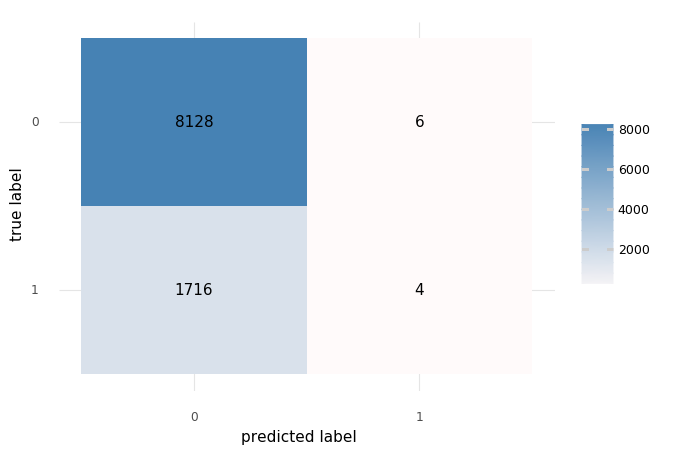

<ggplot: (-9223371920236621645)>

In [21]:
cnf_matrix = confusion_matrix( y_te, grid_gbt.predict(X_te) )
plot_confusion_matrix(cnf_matrix, normalize=False)

### Number of results of sales over 1 mill 1 = over 1 million   0 = under1 mill

In [22]:
df.SalePrice1mill.value_counts()

0    32575
1     6841
Name: SalePrice1mill, dtype: int64

In [23]:
6841/(32575 +6841)

0.1735589608280901

### Confusion matrix result

In [24]:
1720/8134

0.21145807720678633

### Model with more X features (3 "X" features)

In [25]:
# from sklearn.model_selection import train_test_split
# #Define X and y with patsy dmatrices
# X = df[['GROSS SQUARE FEET','LAND SQUARE FEET','BOROUGH' 
          
#           ]] #features we think may help predict y
# y = df['SalePrice1mill'] #what we want to predict



In [26]:
from patsy import dmatrices
y, X = dmatrices('SalePrice1mill ~ Q("YEAR BUILT") + Q("GROSS SQUARE FEET") +Q("LAND SQUARE FEET")',
                 df, return_type = "dataframe")

In [27]:
X_tr, X_te, y_tr, y_te = train_test_split(X, y, random_state=0)

In [28]:
print(len(X_tr))
print(len(X_te))
print(len(y_tr))
print(len(y_te))

29562
9854
29562
9854


### Logistic

In [29]:
# Fit a LogisticRegression here using GridSearchCV (already imported both above)
# Create a params dictionary for the parameter: 'C'
# Use multi_class='multinomial' and solver='lbfgs' in the LogisticRegression

In [30]:
params = {
    'C': [0.1, 1, 10, 100]
}
regression = LogisticRegression()
grid_logit = GridSearchCV(estimator=regression, param_grid=params, verbose=2)
grid_logit.fit(X_tr, y_tr)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] C=0.1 ...........................................................
[CV] ............................................ C=0.1, total=   0.0s
[CV] C=0.1 ...........................................................
[CV] ............................................ C=0.1, total=   0.0s
[CV] C=0.1 ...........................................................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ............................................ C=0.1, total=   0.0s
[CV] C=1 .............................................................
[CV] .............................................. C=1, total=   0.0s
[CV] C=1 .............................................................
[CV] .............................................. C=1, total=   0.0s
[CV] C=1 .............................................................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .............................................. C=1, total=   0.0s
[CV] C=10 ............................................................
[CV] ............................................. C=10, total=   0.0s
[CV] C=10 ............................................................
[CV] ............................................. C=10, total=   0.0s
[CV] C=10 ............................................................
[CV] ............................................. C=10, total=   0.0s

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



[CV] C=100 ...........................................................
[CV] ............................................ C=100, total=   0.0s
[CV] C=100 ...........................................................
[CV] ............................................ C=100, total=   0.0s
[CV] C=100 ...........................................................
[CV] ............................................ C=100, total=   0.0s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.7s finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 

GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [0.1, 1, 10, 100]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring=None, verbose=2)

In [31]:
print(grid_logit.best_score_)

0.8328597523848184


In [32]:
# Calculate test predictions
# Create a test set confusion matrix and plot

## Gradient Boosting

In [33]:
# Fit a GradientBoostingClassifier here using GridSearchCV (already imported both above)
# Create a params dictionary for the parameters:
#      'n_estimators', 'subsample', 'max_depth', 'min_samples_split', 'min_samples_leaf'

In [34]:

params = {
    'n_estimators': [10, 15], 
    'subsample': [0.25, 0.5], 
    'max_depth': [3, 4],
    'min_samples_split': [40, 60],
    'min_samples_leaf': [20, 40]
}
gbt = GradientBoostingClassifier() # RandomForestClassifier()
grid_gbt = GridSearchCV(estimator=gbt, param_grid=params, verbose=2)
grid_gbt.fit(X_tr, y_tr)

Fitting 3 folds for each of 32 candidates, totalling 96 fits
[CV] max_depth=3, min_samples_leaf=20, min_samples_split=40, n_estimators=10, subsample=0.25 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=3, min_samples_leaf=20, min_samples_split=40, n_estimators=10, subsample=0.25, total=   0.1s
[CV] max_depth=3, min_samples_leaf=20, min_samples_split=40, n_estimators=10, subsample=0.25 
[CV]  max_depth=3, min_samples_leaf=20, min_samples_split=40, n_estimators=10, subsample=0.25, total=   0.0s
[CV] max_depth=3, min_samples_leaf=20, min_samples_split=40, n_estimators=10, subsample=0.25 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=3, min_samples_leaf=20, min_samples_split=40, n_estimators=10, subsample=0.25, total=   0.1s
[CV] max_depth=3, min_samples_leaf=20, min_samples_split=40, n_estimators=10, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=3, min_samples_leaf=20, min_samples_split=40, n_estimators=10, subsample=0.5, total=   0.1s
[CV] max_depth=3, min_samples_leaf=20, min_samples_split=40, n_estimators=10, subsample=0.5 
[CV]  max_depth=3, min_samples_leaf=20, min_samples_split=40, n_estimators=10, subsample=0.5, total=   0.1s
[CV] max_depth=3, min_samples_leaf=20, min_samples_split=40, n_estimators=10, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=3, min_samples_leaf=20, min_samples_split=40, n_estimators=10, subsample=0.5, total=   0.1s
[CV] max_depth=3, min_samples_leaf=20, min_samples_split=40, n_estimators=15, subsample=0.25 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=3, min_samples_leaf=20, min_samples_split=40, n_estimators=15, subsample=0.25, total=   0.1s
[CV] max_depth=3, min_samples_leaf=20, min_samples_split=40, n_estimators=15, subsample=0.25 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=3, min_samples_leaf=20, min_samples_split=40, n_estimators=15, subsample=0.25, total=   0.1s
[CV] max_depth=3, min_samples_leaf=20, min_samples_split=40, n_estimators=15, subsample=0.25 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=3, min_samples_leaf=20, min_samples_split=40, n_estimators=15, subsample=0.25, total=   0.1s
[CV] max_depth=3, min_samples_leaf=20, min_samples_split=40, n_estimators=15, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=3, min_samples_leaf=20, min_samples_split=40, n_estimators=15, subsample=0.5, total=   0.2s
[CV] max_depth=3, min_samples_leaf=20, min_samples_split=40, n_estimators=15, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=3, min_samples_leaf=20, min_samples_split=40, n_estimators=15, subsample=0.5, total=   0.2s
[CV] max_depth=3, min_samples_leaf=20, min_samples_split=40, n_estimators=15, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=3, min_samples_leaf=20, min_samples_split=40, n_estimators=15, subsample=0.5, total=   0.2s
[CV] max_depth=3, min_samples_leaf=20, min_samples_split=60, n_estimators=10, subsample=0.25 
[CV]  max_depth=3, min_samples_leaf=20, min_samples_split=60, n_estimators=10, subsample=0.25, total=   0.0s
[CV] max_depth=3, min_samples_leaf=20, min_samples_split=60, n_estimators=10, subsample=0.25 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=3, min_samples_leaf=20, min_samples_split=60, n_estimators=10, subsample=0.25, total=   0.1s
[CV] max_depth=3, min_samples_leaf=20, min_samples_split=60, n_estimators=10, subsample=0.25 
[CV]  max_depth=3, min_samples_leaf=20, min_samples_split=60, n_estimators=10, subsample=0.25, total=   0.1s
[CV] max_depth=3, min_samples_leaf=20, min_samples_split=60, n_estimators=10, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=3, min_samples_leaf=20, min_samples_split=60, n_estimators=10, subsample=0.5, total=   0.1s
[CV] max_depth=3, min_samples_leaf=20, min_samples_split=60, n_estimators=10, subsample=0.5 
[CV]  max_depth=3, min_samples_leaf=20, min_samples_split=60, n_estimators=10, subsample=0.5, total=   0.1s
[CV] max_depth=3, min_samples_leaf=20, min_samples_split=60, n_estimators=10, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=3, min_samples_leaf=20, min_samples_split=60, n_estimators=10, subsample=0.5, total=   0.1s
[CV] max_depth=3, min_samples_leaf=20, min_samples_split=60, n_estimators=15, subsample=0.25 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=3, min_samples_leaf=20, min_samples_split=60, n_estimators=15, subsample=0.25, total=   0.1s
[CV] max_depth=3, min_samples_leaf=20, min_samples_split=60, n_estimators=15, subsample=0.25 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=3, min_samples_leaf=20, min_samples_split=60, n_estimators=15, subsample=0.25, total=   0.1s
[CV] max_depth=3, min_samples_leaf=20, min_samples_split=60, n_estimators=15, subsample=0.25 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=3, min_samples_leaf=20, min_samples_split=60, n_estimators=15, subsample=0.25, total=   0.1s
[CV] max_depth=3, min_samples_leaf=20, min_samples_split=60, n_estimators=15, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=3, min_samples_leaf=20, min_samples_split=60, n_estimators=15, subsample=0.5, total=   0.2s
[CV] max_depth=3, min_samples_leaf=20, min_samples_split=60, n_estimators=15, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=3, min_samples_leaf=20, min_samples_split=60, n_estimators=15, subsample=0.5, total=   0.2s
[CV] max_depth=3, min_samples_leaf=20, min_samples_split=60, n_estimators=15, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=3, min_samples_leaf=20, min_samples_split=60, n_estimators=15, subsample=0.5, total=   0.2s
[CV] max_depth=3, min_samples_leaf=40, min_samples_split=40, n_estimators=10, subsample=0.25 
[CV]  max_depth=3, min_samples_leaf=40, min_samples_split=40, n_estimators=10, subsample=0.25, total=   0.0s
[CV] max_depth=3, min_samples_leaf=40, min_samples_split=40, n_estimators=10, subsample=0.25 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=3, min_samples_leaf=40, min_samples_split=40, n_estimators=10, subsample=0.25, total=   0.0s
[CV] max_depth=3, min_samples_leaf=40, min_samples_split=40, n_estimators=10, subsample=0.25 
[CV]  max_depth=3, min_samples_leaf=40, min_samples_split=40, n_estimators=10, subsample=0.25, total=   0.0s
[CV] max_depth=3, min_samples_leaf=40, min_samples_split=40, n_estimators=10, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=3, min_samples_leaf=40, min_samples_split=40, n_estimators=10, subsample=0.5, total=   0.1s
[CV] max_depth=3, min_samples_leaf=40, min_samples_split=40, n_estimators=10, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=3, min_samples_leaf=40, min_samples_split=40, n_estimators=10, subsample=0.5, total=   0.1s
[CV] max_depth=3, min_samples_leaf=40, min_samples_split=40, n_estimators=10, subsample=0.5 
[CV]  max_depth=3, min_samples_leaf=40, min_samples_split=40, n_estimators=10, subsample=0.5, total=   0.1s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] max_depth=3, min_samples_leaf=40, min_samples_split=40, n_estimators=15, subsample=0.25 
[CV]  max_depth=3, min_samples_leaf=40, min_samples_split=40, n_estimators=15, subsample=0.25, total=   0.1s
[CV] max_depth=3, min_samples_leaf=40, min_samples_split=40, n_estimators=15, subsample=0.25 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=3, min_samples_leaf=40, min_samples_split=40, n_estimators=15, subsample=0.25, total=   0.1s
[CV] max_depth=3, min_samples_leaf=40, min_samples_split=40, n_estimators=15, subsample=0.25 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=3, min_samples_leaf=40, min_samples_split=40, n_estimators=15, subsample=0.25, total=   0.1s
[CV] max_depth=3, min_samples_leaf=40, min_samples_split=40, n_estimators=15, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=3, min_samples_leaf=40, min_samples_split=40, n_estimators=15, subsample=0.5, total=   0.2s
[CV] max_depth=3, min_samples_leaf=40, min_samples_split=40, n_estimators=15, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=3, min_samples_leaf=40, min_samples_split=40, n_estimators=15, subsample=0.5, total=   0.2s
[CV] max_depth=3, min_samples_leaf=40, min_samples_split=40, n_estimators=15, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=3, min_samples_leaf=40, min_samples_split=40, n_estimators=15, subsample=0.5, total=   0.2s
[CV] max_depth=3, min_samples_leaf=40, min_samples_split=60, n_estimators=10, subsample=0.25 
[CV]  max_depth=3, min_samples_leaf=40, min_samples_split=60, n_estimators=10, subsample=0.25, total=   0.1s
[CV] max_depth=3, min_samples_leaf=40, min_samples_split=60, n_estimators=10, subsample=0.25 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=3, min_samples_leaf=40, min_samples_split=60, n_estimators=10, subsample=0.25, total=   0.1s
[CV] max_depth=3, min_samples_leaf=40, min_samples_split=60, n_estimators=10, subsample=0.25 
[CV]  max_depth=3, min_samples_leaf=40, min_samples_split=60, n_estimators=10, subsample=0.25, total=   0.0s
[CV] max_depth=3, min_samples_leaf=40, min_samples_split=60, n_estimators=10, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=3, min_samples_leaf=40, min_samples_split=60, n_estimators=10, subsample=0.5, total=   0.1s
[CV] max_depth=3, min_samples_leaf=40, min_samples_split=60, n_estimators=10, subsample=0.5 
[CV]  max_depth=3, min_samples_leaf=40, min_samples_split=60, n_estimators=10, subsample=0.5, total=   0.1s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] max_depth=3, min_samples_leaf=40, min_samples_split=60, n_estimators=10, subsample=0.5 
[CV]  max_depth=3, min_samples_leaf=40, min_samples_split=60, n_estimators=10, subsample=0.5, total=   0.1s
[CV] max_depth=3, min_samples_leaf=40, min_samples_split=60, n_estimators=15, subsample=0.25 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=3, min_samples_leaf=40, min_samples_split=60, n_estimators=15, subsample=0.25, total=   0.1s
[CV] max_depth=3, min_samples_leaf=40, min_samples_split=60, n_estimators=15, subsample=0.25 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=3, min_samples_leaf=40, min_samples_split=60, n_estimators=15, subsample=0.25, total=   0.1s
[CV] max_depth=3, min_samples_leaf=40, min_samples_split=60, n_estimators=15, subsample=0.25 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=3, min_samples_leaf=40, min_samples_split=60, n_estimators=15, subsample=0.25, total=   0.1s
[CV] max_depth=3, min_samples_leaf=40, min_samples_split=60, n_estimators=15, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=3, min_samples_leaf=40, min_samples_split=60, n_estimators=15, subsample=0.5, total=   0.2s
[CV] max_depth=3, min_samples_leaf=40, min_samples_split=60, n_estimators=15, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=3, min_samples_leaf=40, min_samples_split=60, n_estimators=15, subsample=0.5, total=   0.2s
[CV] max_depth=3, min_samples_leaf=40, min_samples_split=60, n_estimators=15, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=3, min_samples_leaf=40, min_samples_split=60, n_estimators=15, subsample=0.5, total=   0.2s
[CV] max_depth=4, min_samples_leaf=20, min_samples_split=40, n_estimators=10, subsample=0.25 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=4, min_samples_leaf=20, min_samples_split=40, n_estimators=10, subsample=0.25, total=   0.1s
[CV] max_depth=4, min_samples_leaf=20, min_samples_split=40, n_estimators=10, subsample=0.25 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=4, min_samples_leaf=20, min_samples_split=40, n_estimators=10, subsample=0.25, total=   0.1s
[CV] max_depth=4, min_samples_leaf=20, min_samples_split=40, n_estimators=10, subsample=0.25 
[CV]  max_depth=4, min_samples_leaf=20, min_samples_split=40, n_estimators=10, subsample=0.25, total=   0.1s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] max_depth=4, min_samples_leaf=20, min_samples_split=40, n_estimators=10, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=4, min_samples_leaf=20, min_samples_split=40, n_estimators=10, subsample=0.5, total=   0.1s
[CV] max_depth=4, min_samples_leaf=20, min_samples_split=40, n_estimators=10, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=4, min_samples_leaf=20, min_samples_split=40, n_estimators=10, subsample=0.5, total=   0.1s
[CV] max_depth=4, min_samples_leaf=20, min_samples_split=40, n_estimators=10, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=4, min_samples_leaf=20, min_samples_split=40, n_estimators=10, subsample=0.5, total=   0.1s
[CV] max_depth=4, min_samples_leaf=20, min_samples_split=40, n_estimators=15, subsample=0.25 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=4, min_samples_leaf=20, min_samples_split=40, n_estimators=15, subsample=0.25, total=   0.2s
[CV] max_depth=4, min_samples_leaf=20, min_samples_split=40, n_estimators=15, subsample=0.25 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=4, min_samples_leaf=20, min_samples_split=40, n_estimators=15, subsample=0.25, total=   0.1s
[CV] max_depth=4, min_samples_leaf=20, min_samples_split=40, n_estimators=15, subsample=0.25 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=4, min_samples_leaf=20, min_samples_split=40, n_estimators=15, subsample=0.25, total=   0.2s
[CV] max_depth=4, min_samples_leaf=20, min_samples_split=40, n_estimators=15, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=4, min_samples_leaf=20, min_samples_split=40, n_estimators=15, subsample=0.5, total=   0.2s
[CV] max_depth=4, min_samples_leaf=20, min_samples_split=40, n_estimators=15, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=4, min_samples_leaf=20, min_samples_split=40, n_estimators=15, subsample=0.5, total=   0.2s
[CV] max_depth=4, min_samples_leaf=20, min_samples_split=40, n_estimators=15, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=4, min_samples_leaf=20, min_samples_split=40, n_estimators=15, subsample=0.5, total=   0.2s
[CV] max_depth=4, min_samples_leaf=20, min_samples_split=60, n_estimators=10, subsample=0.25 
[CV]  max_depth=4, min_samples_leaf=20, min_samples_split=60, n_estimators=10, subsample=0.25, total=   0.1s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] max_depth=4, min_samples_leaf=20, min_samples_split=60, n_estimators=10, subsample=0.25 
[CV]  max_depth=4, min_samples_leaf=20, min_samples_split=60, n_estimators=10, subsample=0.25, total=   0.1s
[CV] max_depth=4, min_samples_leaf=20, min_samples_split=60, n_estimators=10, subsample=0.25 
[CV]  max_depth=4, min_samples_leaf=20, min_samples_split=60, n_estimators=10, subsample=0.25, total=   0.1s
[CV] max_depth=4, min_samples_leaf=20, min_samples_split=60, n_estimators=10, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=4, min_samples_leaf=20, min_samples_split=60, n_estimators=10, subsample=0.5, total=   0.1s
[CV] max_depth=4, min_samples_leaf=20, min_samples_split=60, n_estimators=10, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=4, min_samples_leaf=20, min_samples_split=60, n_estimators=10, subsample=0.5, total=   0.1s
[CV] max_depth=4, min_samples_leaf=20, min_samples_split=60, n_estimators=10, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=4, min_samples_leaf=20, min_samples_split=60, n_estimators=10, subsample=0.5, total=   0.1s
[CV] max_depth=4, min_samples_leaf=20, min_samples_split=60, n_estimators=15, subsample=0.25 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=4, min_samples_leaf=20, min_samples_split=60, n_estimators=15, subsample=0.25, total=   0.2s
[CV] max_depth=4, min_samples_leaf=20, min_samples_split=60, n_estimators=15, subsample=0.25 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=4, min_samples_leaf=20, min_samples_split=60, n_estimators=15, subsample=0.25, total=   0.1s
[CV] max_depth=4, min_samples_leaf=20, min_samples_split=60, n_estimators=15, subsample=0.25 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=4, min_samples_leaf=20, min_samples_split=60, n_estimators=15, subsample=0.25, total=   0.2s
[CV] max_depth=4, min_samples_leaf=20, min_samples_split=60, n_estimators=15, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=4, min_samples_leaf=20, min_samples_split=60, n_estimators=15, subsample=0.5, total=   0.2s
[CV] max_depth=4, min_samples_leaf=20, min_samples_split=60, n_estimators=15, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=4, min_samples_leaf=20, min_samples_split=60, n_estimators=15, subsample=0.5, total=   0.2s
[CV] max_depth=4, min_samples_leaf=20, min_samples_split=60, n_estimators=15, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=4, min_samples_leaf=20, min_samples_split=60, n_estimators=15, subsample=0.5, total=   0.2s
[CV] max_depth=4, min_samples_leaf=40, min_samples_split=40, n_estimators=10, subsample=0.25 
[CV]  max_depth=4, min_samples_leaf=40, min_samples_split=40, n_estimators=10, subsample=0.25, total=   0.1s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] max_depth=4, min_samples_leaf=40, min_samples_split=40, n_estimators=10, subsample=0.25 
[CV]  max_depth=4, min_samples_leaf=40, min_samples_split=40, n_estimators=10, subsample=0.25, total=   0.1s
[CV] max_depth=4, min_samples_leaf=40, min_samples_split=40, n_estimators=10, subsample=0.25 
[CV]  max_depth=4, min_samples_leaf=40, min_samples_split=40, n_estimators=10, subsample=0.25, total=   0.1s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] max_depth=4, min_samples_leaf=40, min_samples_split=40, n_estimators=10, subsample=0.5 
[CV]  max_depth=4, min_samples_leaf=40, min_samples_split=40, n_estimators=10, subsample=0.5, total=   0.1s
[CV] max_depth=4, min_samples_leaf=40, min_samples_split=40, n_estimators=10, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=4, min_samples_leaf=40, min_samples_split=40, n_estimators=10, subsample=0.5, total=   0.1s
[CV] max_depth=4, min_samples_leaf=40, min_samples_split=40, n_estimators=10, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=4, min_samples_leaf=40, min_samples_split=40, n_estimators=10, subsample=0.5, total=   0.1s
[CV] max_depth=4, min_samples_leaf=40, min_samples_split=40, n_estimators=15, subsample=0.25 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=4, min_samples_leaf=40, min_samples_split=40, n_estimators=15, subsample=0.25, total=   0.1s
[CV] max_depth=4, min_samples_leaf=40, min_samples_split=40, n_estimators=15, subsample=0.25 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=4, min_samples_leaf=40, min_samples_split=40, n_estimators=15, subsample=0.25, total=   0.2s
[CV] max_depth=4, min_samples_leaf=40, min_samples_split=40, n_estimators=15, subsample=0.25 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=4, min_samples_leaf=40, min_samples_split=40, n_estimators=15, subsample=0.25, total=   0.1s
[CV] max_depth=4, min_samples_leaf=40, min_samples_split=40, n_estimators=15, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=4, min_samples_leaf=40, min_samples_split=40, n_estimators=15, subsample=0.5, total=   0.2s
[CV] max_depth=4, min_samples_leaf=40, min_samples_split=40, n_estimators=15, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=4, min_samples_leaf=40, min_samples_split=40, n_estimators=15, subsample=0.5, total=   0.2s
[CV] max_depth=4, min_samples_leaf=40, min_samples_split=40, n_estimators=15, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=4, min_samples_leaf=40, min_samples_split=40, n_estimators=15, subsample=0.5, total=   0.2s
[CV] max_depth=4, min_samples_leaf=40, min_samples_split=60, n_estimators=10, subsample=0.25 
[CV]  max_depth=4, min_samples_leaf=40, min_samples_split=60, n_estimators=10, subsample=0.25, total=   0.1s
[CV] max_depth=4, min_samples_leaf=40, min_samples_split=60, n_estimators=10, subsample=0.25 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=4, min_samples_leaf=40, min_samples_split=60, n_estimators=10, subsample=0.25, total=   0.1s
[CV] max_depth=4, min_samples_leaf=40, min_samples_split=60, n_estimators=10, subsample=0.25 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=4, min_samples_leaf=40, min_samples_split=60, n_estimators=10, subsample=0.25, total=   0.1s
[CV] max_depth=4, min_samples_leaf=40, min_samples_split=60, n_estimators=10, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=4, min_samples_leaf=40, min_samples_split=60, n_estimators=10, subsample=0.5, total=   0.1s
[CV] max_depth=4, min_samples_leaf=40, min_samples_split=60, n_estimators=10, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=4, min_samples_leaf=40, min_samples_split=60, n_estimators=10, subsample=0.5, total=   0.1s
[CV] max_depth=4, min_samples_leaf=40, min_samples_split=60, n_estimators=10, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=4, min_samples_leaf=40, min_samples_split=60, n_estimators=10, subsample=0.5, total=   0.1s
[CV] max_depth=4, min_samples_leaf=40, min_samples_split=60, n_estimators=15, subsample=0.25 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=4, min_samples_leaf=40, min_samples_split=60, n_estimators=15, subsample=0.25, total=   0.2s
[CV] max_depth=4, min_samples_leaf=40, min_samples_split=60, n_estimators=15, subsample=0.25 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=4, min_samples_leaf=40, min_samples_split=60, n_estimators=15, subsample=0.25, total=   0.2s
[CV] max_depth=4, min_samples_leaf=40, min_samples_split=60, n_estimators=15, subsample=0.25 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=4, min_samples_leaf=40, min_samples_split=60, n_estimators=15, subsample=0.25, total=   0.2s
[CV] max_depth=4, min_samples_leaf=40, min_samples_split=60, n_estimators=15, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=4, min_samples_leaf=40, min_samples_split=60, n_estimators=15, subsample=0.5, total=   0.2s
[CV] max_depth=4, min_samples_leaf=40, min_samples_split=60, n_estimators=15, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=4, min_samples_leaf=40, min_samples_split=60, n_estimators=15, subsample=0.5, total=   0.2s
[CV] max_depth=4, min_samples_leaf=40, min_samples_split=60, n_estimators=15, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=4, min_samples_leaf=40, min_samples_split=60, n_estimators=15, subsample=0.5, total=   0.2s


[Parallel(n_jobs=1)]: Done  96 out of  96 | elapsed:   23.3s finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GridSearchCV(cv=None, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [10, 15], 'subsample': [0.25, 0.5], 'max_depth': [3, 4], 'min_samples_split': [40, 60], 'min_samples_leaf': [20, 40]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

In [35]:
# Print the best model, best test score (and associated train score)

In [36]:
print(grid_gbt.best_estimator_)
print(grid_gbt.best_score_)
pd.DataFrame(grid_gbt.cv_results_)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=4,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=40, min_samples_split=40,
              min_weight_fraction_leaf=0.0, n_estimators=15,
              presort='auto', random_state=None, subsample=0.5, verbose=0,
              warm_start=False)
0.8368513632365875


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\util

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_n_estimators,param_subsample,params,...,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0.150249,0.014004,0.010461,0.007397,3,20,40,10,0.25,"{'max_depth': 3, 'min_samples_leaf': 20, 'min_...",...,0.831642,0.832961,0.831676,0.001036,24,0.832961,0.833215,0.833773,0.833316,0.000339
1,0.182405,0.008653,0.002932,0.004146,3,20,40,10,0.5,"{'max_depth': 3, 'min_samples_leaf': 20, 'min_...",...,0.830120,0.831946,0.831067,0.000747,26,0.831743,0.831642,0.831084,0.831490,0.000290
2,0.215745,0.008479,0.005706,0.002066,3,20,40,15,0.25,"{'max_depth': 3, 'min_samples_leaf': 20, 'min_...",...,0.836513,0.835397,0.835261,0.001081,11,0.836919,0.836716,0.836006,0.836547,0.000392
3,0.256082,0.008900,0.008986,0.002113,3,20,40,15,0.5,"{'max_depth': 3, 'min_samples_leaf': 20, 'min_...",...,0.835397,0.835092,0.834483,0.001084,16,0.837579,0.836767,0.836107,0.836818,0.000602
4,0.148735,0.004652,0.005248,0.007422,3,20,60,10,0.25,"{'max_depth': 3, 'min_samples_leaf': 20, 'min_...",...,0.829815,0.831033,0.830492,0.000506,29,0.831743,0.831084,0.831946,0.831591,0.000368
5,0.178478,0.004298,0.006389,0.006687,3,20,60,10,0.5,"{'max_depth': 3, 'min_samples_leaf': 20, 'min_...",...,0.830120,0.831845,0.830999,0.000705,27,0.832606,0.831338,0.831896,0.831946,0.000519
6,0.214040,0.007640,0.005099,0.002485,3,20,60,15,0.25,"{'max_depth': 3, 'min_samples_leaf': 20, 'min_...",...,0.834179,0.835397,0.835126,0.000690,12,0.837325,0.836970,0.837122,0.837139,0.000145
7,0.252638,0.008613,0.010122,0.004272,3,20,60,15,0.5,"{'max_depth': 3, 'min_samples_leaf': 20, 'min_...",...,0.836209,0.835803,0.835498,0.000736,9,0.836158,0.836665,0.836107,0.836310,0.000252
8,0.146384,0.000707,0.000000,0.000000,3,40,40,10,0.25,"{'max_depth': 3, 'min_samples_leaf': 40, 'min_...",...,0.828902,0.829206,0.829646,0.000846,32,0.831540,0.830526,0.829714,0.830593,0.000747
9,0.175161,0.009677,0.010458,0.007395,3,40,40,10,0.5,"{'max_depth': 3, 'min_samples_leaf': 40, 'min_...",...,0.828800,0.830627,0.829748,0.000747,31,0.831084,0.830120,0.830881,0.830695,0.000415


In [37]:
# Calculate test predictions
# Create a test set confusion matrix and plot

### Confusion Matrix

C:\ProgramData\Anaconda3\lib\site-packages\plotnine\utils.py:281: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  ndistinct = ids.apply(len_unique, axis=0).as_matrix()
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:4388: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  object.__getattribute__(self, name)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:4389: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  return object.__setattr__(self, name, value)


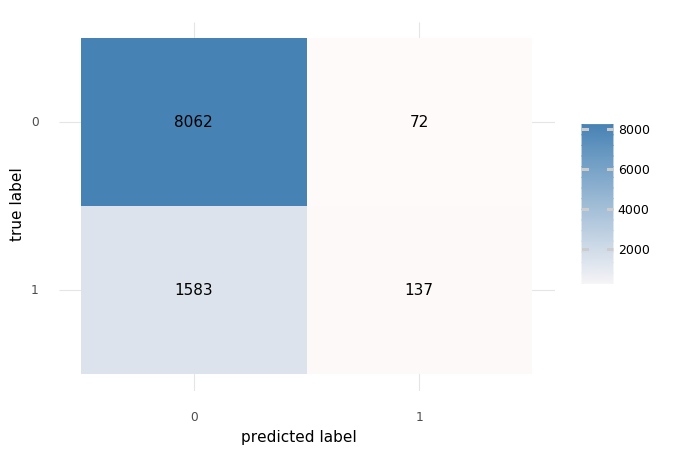

<ggplot: (-9223371920236629595)>

In [38]:
cnf_matrix = confusion_matrix( y_te, grid_logit.predict(X_te) )
plot_confusion_matrix(cnf_matrix, normalize=False)


In [39]:
(8062+137)/(1583+72+137+8062)

0.8320478993302213

### Another analysis with more  "X"  5 features 

In [40]:
# from sklearn.model_selection import train_test_split
# #Define X and y with patsy dmatrices
# X = df[['GROSS SQUARE FEET','LAND SQUARE FEET','BOROUGH', 'BUILDING CLASS CATEGORY'
          
#           ]] #features we think may help predict y
# y = df['SalePrice1mill'] #what we want to predict 
# #X_tr, X_te, y_tr, y_te = train_test_split(X, y, random_state = 0)
# #A brief preview of our train test split
# #print(len(X_tr), len(X_te), len(y_tr), len(y_te))





In [41]:
from patsy import dmatrices
y, X = dmatrices('SalePrice1mill ~ BOROUGH + Q("GROSS SQUARE FEET") +Q("LAND SQUARE FEET")+Q("BUILDING CLASS CATEGORY")+Q("YEAR BUILT") ',
                 df, return_type = "dataframe")

In [42]:
X_tr, X_te, y_tr, y_te = train_test_split(X, y, random_state=0)

### Logistic

In [43]:
params = {
    'C': [0.1, 1, 10, 100]
}
regression = LogisticRegression()
grid_logit = GridSearchCV(estimator=regression, param_grid=params, verbose=1)
grid_logit.fit(X_tr, y_tr)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), 

GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [0.1, 1, 10, 100]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring=None, verbose=1)

In [44]:
print(grid_logit.best_score_)

0.8341790135985386


### Gradient Boosting

In [45]:
params = {
    'n_estimators': [10, 15], 
    'subsample': [0.25, 0.5], 
    'max_depth': [3, 4],
    'min_samples_split': [40, 60],
    'min_samples_leaf': [20, 40]
}
gbt = GradientBoostingClassifier() # RandomForestClassifier()
grid_gbt = GridSearchCV(estimator=gbt, param_grid=params, verbose=2)
grid_gbt.fit(X_tr, y_tr)

Fitting 3 folds for each of 32 candidates, totalling 96 fits
[CV] max_depth=3, min_samples_leaf=20, min_samples_split=40, n_estimators=10, subsample=0.25 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=3, min_samples_leaf=20, min_samples_split=40, n_estimators=10, subsample=0.25, total=   0.4s
[CV] max_depth=3, min_samples_leaf=20, min_samples_split=40, n_estimators=10, subsample=0.25 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=3, min_samples_leaf=20, min_samples_split=40, n_estimators=10, subsample=0.25, total=   0.3s
[CV] max_depth=3, min_samples_leaf=20, min_samples_split=40, n_estimators=10, subsample=0.25 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=3, min_samples_leaf=20, min_samples_split=40, n_estimators=10, subsample=0.25, total=   0.3s
[CV] max_depth=3, min_samples_leaf=20, min_samples_split=40, n_estimators=10, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=3, min_samples_leaf=20, min_samples_split=40, n_estimators=10, subsample=0.5, total=   0.5s
[CV] max_depth=3, min_samples_leaf=20, min_samples_split=40, n_estimators=10, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=3, min_samples_leaf=20, min_samples_split=40, n_estimators=10, subsample=0.5, total=   0.5s
[CV] max_depth=3, min_samples_leaf=20, min_samples_split=40, n_estimators=10, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=3, min_samples_leaf=20, min_samples_split=40, n_estimators=10, subsample=0.5, total=   0.5s
[CV] max_depth=3, min_samples_leaf=20, min_samples_split=40, n_estimators=15, subsample=0.25 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=3, min_samples_leaf=20, min_samples_split=40, n_estimators=15, subsample=0.25, total=   0.5s
[CV] max_depth=3, min_samples_leaf=20, min_samples_split=40, n_estimators=15, subsample=0.25 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=3, min_samples_leaf=20, min_samples_split=40, n_estimators=15, subsample=0.25, total=   0.5s
[CV] max_depth=3, min_samples_leaf=20, min_samples_split=40, n_estimators=15, subsample=0.25 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=3, min_samples_leaf=20, min_samples_split=40, n_estimators=15, subsample=0.25, total=   0.5s
[CV] max_depth=3, min_samples_leaf=20, min_samples_split=40, n_estimators=15, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=3, min_samples_leaf=20, min_samples_split=40, n_estimators=15, subsample=0.5, total=   0.8s
[CV] max_depth=3, min_samples_leaf=20, min_samples_split=40, n_estimators=15, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=3, min_samples_leaf=20, min_samples_split=40, n_estimators=15, subsample=0.5, total=   0.8s
[CV] max_depth=3, min_samples_leaf=20, min_samples_split=40, n_estimators=15, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=3, min_samples_leaf=20, min_samples_split=40, n_estimators=15, subsample=0.5, total=   0.8s
[CV] max_depth=3, min_samples_leaf=20, min_samples_split=60, n_estimators=10, subsample=0.25 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=3, min_samples_leaf=20, min_samples_split=60, n_estimators=10, subsample=0.25, total=   0.3s
[CV] max_depth=3, min_samples_leaf=20, min_samples_split=60, n_estimators=10, subsample=0.25 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=3, min_samples_leaf=20, min_samples_split=60, n_estimators=10, subsample=0.25, total=   0.3s
[CV] max_depth=3, min_samples_leaf=20, min_samples_split=60, n_estimators=10, subsample=0.25 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=3, min_samples_leaf=20, min_samples_split=60, n_estimators=10, subsample=0.25, total=   0.3s
[CV] max_depth=3, min_samples_leaf=20, min_samples_split=60, n_estimators=10, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=3, min_samples_leaf=20, min_samples_split=60, n_estimators=10, subsample=0.5, total=   0.5s
[CV] max_depth=3, min_samples_leaf=20, min_samples_split=60, n_estimators=10, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=3, min_samples_leaf=20, min_samples_split=60, n_estimators=10, subsample=0.5, total=   0.5s
[CV] max_depth=3, min_samples_leaf=20, min_samples_split=60, n_estimators=10, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=3, min_samples_leaf=20, min_samples_split=60, n_estimators=10, subsample=0.5, total=   0.5s
[CV] max_depth=3, min_samples_leaf=20, min_samples_split=60, n_estimators=15, subsample=0.25 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=3, min_samples_leaf=20, min_samples_split=60, n_estimators=15, subsample=0.25, total=   0.5s
[CV] max_depth=3, min_samples_leaf=20, min_samples_split=60, n_estimators=15, subsample=0.25 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=3, min_samples_leaf=20, min_samples_split=60, n_estimators=15, subsample=0.25, total=   0.5s
[CV] max_depth=3, min_samples_leaf=20, min_samples_split=60, n_estimators=15, subsample=0.25 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=3, min_samples_leaf=20, min_samples_split=60, n_estimators=15, subsample=0.25, total=   0.5s
[CV] max_depth=3, min_samples_leaf=20, min_samples_split=60, n_estimators=15, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=3, min_samples_leaf=20, min_samples_split=60, n_estimators=15, subsample=0.5, total=   0.8s
[CV] max_depth=3, min_samples_leaf=20, min_samples_split=60, n_estimators=15, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=3, min_samples_leaf=20, min_samples_split=60, n_estimators=15, subsample=0.5, total=   0.7s
[CV] max_depth=3, min_samples_leaf=20, min_samples_split=60, n_estimators=15, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=3, min_samples_leaf=20, min_samples_split=60, n_estimators=15, subsample=0.5, total=   0.7s
[CV] max_depth=3, min_samples_leaf=40, min_samples_split=40, n_estimators=10, subsample=0.25 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=3, min_samples_leaf=40, min_samples_split=40, n_estimators=10, subsample=0.25, total=   0.3s
[CV] max_depth=3, min_samples_leaf=40, min_samples_split=40, n_estimators=10, subsample=0.25 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=3, min_samples_leaf=40, min_samples_split=40, n_estimators=10, subsample=0.25, total=   0.3s
[CV] max_depth=3, min_samples_leaf=40, min_samples_split=40, n_estimators=10, subsample=0.25 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=3, min_samples_leaf=40, min_samples_split=40, n_estimators=10, subsample=0.25, total=   0.3s
[CV] max_depth=3, min_samples_leaf=40, min_samples_split=40, n_estimators=10, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=3, min_samples_leaf=40, min_samples_split=40, n_estimators=10, subsample=0.5, total=   0.5s
[CV] max_depth=3, min_samples_leaf=40, min_samples_split=40, n_estimators=10, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=3, min_samples_leaf=40, min_samples_split=40, n_estimators=10, subsample=0.5, total=   0.5s
[CV] max_depth=3, min_samples_leaf=40, min_samples_split=40, n_estimators=10, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=3, min_samples_leaf=40, min_samples_split=40, n_estimators=10, subsample=0.5, total=   0.5s
[CV] max_depth=3, min_samples_leaf=40, min_samples_split=40, n_estimators=15, subsample=0.25 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=3, min_samples_leaf=40, min_samples_split=40, n_estimators=15, subsample=0.25, total=   0.5s
[CV] max_depth=3, min_samples_leaf=40, min_samples_split=40, n_estimators=15, subsample=0.25 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=3, min_samples_leaf=40, min_samples_split=40, n_estimators=15, subsample=0.25, total=   0.5s
[CV] max_depth=3, min_samples_leaf=40, min_samples_split=40, n_estimators=15, subsample=0.25 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=3, min_samples_leaf=40, min_samples_split=40, n_estimators=15, subsample=0.25, total=   0.5s
[CV] max_depth=3, min_samples_leaf=40, min_samples_split=40, n_estimators=15, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=3, min_samples_leaf=40, min_samples_split=40, n_estimators=15, subsample=0.5, total=   0.7s
[CV] max_depth=3, min_samples_leaf=40, min_samples_split=40, n_estimators=15, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=3, min_samples_leaf=40, min_samples_split=40, n_estimators=15, subsample=0.5, total=   0.7s
[CV] max_depth=3, min_samples_leaf=40, min_samples_split=40, n_estimators=15, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=3, min_samples_leaf=40, min_samples_split=40, n_estimators=15, subsample=0.5, total=   0.7s
[CV] max_depth=3, min_samples_leaf=40, min_samples_split=60, n_estimators=10, subsample=0.25 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=3, min_samples_leaf=40, min_samples_split=60, n_estimators=10, subsample=0.25, total=   0.3s
[CV] max_depth=3, min_samples_leaf=40, min_samples_split=60, n_estimators=10, subsample=0.25 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=3, min_samples_leaf=40, min_samples_split=60, n_estimators=10, subsample=0.25, total=   0.3s
[CV] max_depth=3, min_samples_leaf=40, min_samples_split=60, n_estimators=10, subsample=0.25 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=3, min_samples_leaf=40, min_samples_split=60, n_estimators=10, subsample=0.25, total=   0.3s
[CV] max_depth=3, min_samples_leaf=40, min_samples_split=60, n_estimators=10, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=3, min_samples_leaf=40, min_samples_split=60, n_estimators=10, subsample=0.5, total=   0.5s
[CV] max_depth=3, min_samples_leaf=40, min_samples_split=60, n_estimators=10, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=3, min_samples_leaf=40, min_samples_split=60, n_estimators=10, subsample=0.5, total=   0.5s
[CV] max_depth=3, min_samples_leaf=40, min_samples_split=60, n_estimators=10, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=3, min_samples_leaf=40, min_samples_split=60, n_estimators=10, subsample=0.5, total=   0.5s
[CV] max_depth=3, min_samples_leaf=40, min_samples_split=60, n_estimators=15, subsample=0.25 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=3, min_samples_leaf=40, min_samples_split=60, n_estimators=15, subsample=0.25, total=   0.5s
[CV] max_depth=3, min_samples_leaf=40, min_samples_split=60, n_estimators=15, subsample=0.25 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=3, min_samples_leaf=40, min_samples_split=60, n_estimators=15, subsample=0.25, total=   0.5s
[CV] max_depth=3, min_samples_leaf=40, min_samples_split=60, n_estimators=15, subsample=0.25 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=3, min_samples_leaf=40, min_samples_split=60, n_estimators=15, subsample=0.25, total=   0.5s
[CV] max_depth=3, min_samples_leaf=40, min_samples_split=60, n_estimators=15, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=3, min_samples_leaf=40, min_samples_split=60, n_estimators=15, subsample=0.5, total=   0.8s
[CV] max_depth=3, min_samples_leaf=40, min_samples_split=60, n_estimators=15, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=3, min_samples_leaf=40, min_samples_split=60, n_estimators=15, subsample=0.5, total=   0.7s
[CV] max_depth=3, min_samples_leaf=40, min_samples_split=60, n_estimators=15, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=3, min_samples_leaf=40, min_samples_split=60, n_estimators=15, subsample=0.5, total=   0.7s
[CV] max_depth=4, min_samples_leaf=20, min_samples_split=40, n_estimators=10, subsample=0.25 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=4, min_samples_leaf=20, min_samples_split=40, n_estimators=10, subsample=0.25, total=   0.4s
[CV] max_depth=4, min_samples_leaf=20, min_samples_split=40, n_estimators=10, subsample=0.25 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=4, min_samples_leaf=20, min_samples_split=40, n_estimators=10, subsample=0.25, total=   0.4s
[CV] max_depth=4, min_samples_leaf=20, min_samples_split=40, n_estimators=10, subsample=0.25 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=4, min_samples_leaf=20, min_samples_split=40, n_estimators=10, subsample=0.25, total=   0.4s
[CV] max_depth=4, min_samples_leaf=20, min_samples_split=40, n_estimators=10, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=4, min_samples_leaf=20, min_samples_split=40, n_estimators=10, subsample=0.5, total=   0.6s
[CV] max_depth=4, min_samples_leaf=20, min_samples_split=40, n_estimators=10, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=4, min_samples_leaf=20, min_samples_split=40, n_estimators=10, subsample=0.5, total=   0.6s
[CV] max_depth=4, min_samples_leaf=20, min_samples_split=40, n_estimators=10, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=4, min_samples_leaf=20, min_samples_split=40, n_estimators=10, subsample=0.5, total=   0.6s
[CV] max_depth=4, min_samples_leaf=20, min_samples_split=40, n_estimators=15, subsample=0.25 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=4, min_samples_leaf=20, min_samples_split=40, n_estimators=15, subsample=0.25, total=   0.6s
[CV] max_depth=4, min_samples_leaf=20, min_samples_split=40, n_estimators=15, subsample=0.25 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=4, min_samples_leaf=20, min_samples_split=40, n_estimators=15, subsample=0.25, total=   0.6s
[CV] max_depth=4, min_samples_leaf=20, min_samples_split=40, n_estimators=15, subsample=0.25 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=4, min_samples_leaf=20, min_samples_split=40, n_estimators=15, subsample=0.25, total=   0.6s
[CV] max_depth=4, min_samples_leaf=20, min_samples_split=40, n_estimators=15, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=4, min_samples_leaf=20, min_samples_split=40, n_estimators=15, subsample=0.5, total=   1.0s
[CV] max_depth=4, min_samples_leaf=20, min_samples_split=40, n_estimators=15, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=4, min_samples_leaf=20, min_samples_split=40, n_estimators=15, subsample=0.5, total=   1.0s
[CV] max_depth=4, min_samples_leaf=20, min_samples_split=40, n_estimators=15, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=4, min_samples_leaf=20, min_samples_split=40, n_estimators=15, subsample=0.5, total=   0.9s
[CV] max_depth=4, min_samples_leaf=20, min_samples_split=60, n_estimators=10, subsample=0.25 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=4, min_samples_leaf=20, min_samples_split=60, n_estimators=10, subsample=0.25, total=   0.4s
[CV] max_depth=4, min_samples_leaf=20, min_samples_split=60, n_estimators=10, subsample=0.25 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=4, min_samples_leaf=20, min_samples_split=60, n_estimators=10, subsample=0.25, total=   0.4s
[CV] max_depth=4, min_samples_leaf=20, min_samples_split=60, n_estimators=10, subsample=0.25 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=4, min_samples_leaf=20, min_samples_split=60, n_estimators=10, subsample=0.25, total=   0.4s
[CV] max_depth=4, min_samples_leaf=20, min_samples_split=60, n_estimators=10, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=4, min_samples_leaf=20, min_samples_split=60, n_estimators=10, subsample=0.5, total=   0.7s
[CV] max_depth=4, min_samples_leaf=20, min_samples_split=60, n_estimators=10, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=4, min_samples_leaf=20, min_samples_split=60, n_estimators=10, subsample=0.5, total=   0.8s
[CV] max_depth=4, min_samples_leaf=20, min_samples_split=60, n_estimators=10, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=4, min_samples_leaf=20, min_samples_split=60, n_estimators=10, subsample=0.5, total=   0.7s
[CV] max_depth=4, min_samples_leaf=20, min_samples_split=60, n_estimators=15, subsample=0.25 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=4, min_samples_leaf=20, min_samples_split=60, n_estimators=15, subsample=0.25, total=   0.8s
[CV] max_depth=4, min_samples_leaf=20, min_samples_split=60, n_estimators=15, subsample=0.25 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=4, min_samples_leaf=20, min_samples_split=60, n_estimators=15, subsample=0.25, total=   0.7s
[CV] max_depth=4, min_samples_leaf=20, min_samples_split=60, n_estimators=15, subsample=0.25 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=4, min_samples_leaf=20, min_samples_split=60, n_estimators=15, subsample=0.25, total=   0.7s
[CV] max_depth=4, min_samples_leaf=20, min_samples_split=60, n_estimators=15, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=4, min_samples_leaf=20, min_samples_split=60, n_estimators=15, subsample=0.5, total=   1.0s
[CV] max_depth=4, min_samples_leaf=20, min_samples_split=60, n_estimators=15, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=4, min_samples_leaf=20, min_samples_split=60, n_estimators=15, subsample=0.5, total=   0.9s
[CV] max_depth=4, min_samples_leaf=20, min_samples_split=60, n_estimators=15, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=4, min_samples_leaf=20, min_samples_split=60, n_estimators=15, subsample=0.5, total=   0.9s
[CV] max_depth=4, min_samples_leaf=40, min_samples_split=40, n_estimators=10, subsample=0.25 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=4, min_samples_leaf=40, min_samples_split=40, n_estimators=10, subsample=0.25, total=   0.4s
[CV] max_depth=4, min_samples_leaf=40, min_samples_split=40, n_estimators=10, subsample=0.25 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=4, min_samples_leaf=40, min_samples_split=40, n_estimators=10, subsample=0.25, total=   0.4s
[CV] max_depth=4, min_samples_leaf=40, min_samples_split=40, n_estimators=10, subsample=0.25 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=4, min_samples_leaf=40, min_samples_split=40, n_estimators=10, subsample=0.25, total=   0.4s
[CV] max_depth=4, min_samples_leaf=40, min_samples_split=40, n_estimators=10, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=4, min_samples_leaf=40, min_samples_split=40, n_estimators=10, subsample=0.5, total=   0.6s
[CV] max_depth=4, min_samples_leaf=40, min_samples_split=40, n_estimators=10, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=4, min_samples_leaf=40, min_samples_split=40, n_estimators=10, subsample=0.5, total=   0.6s
[CV] max_depth=4, min_samples_leaf=40, min_samples_split=40, n_estimators=10, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=4, min_samples_leaf=40, min_samples_split=40, n_estimators=10, subsample=0.5, total=   0.6s
[CV] max_depth=4, min_samples_leaf=40, min_samples_split=40, n_estimators=15, subsample=0.25 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=4, min_samples_leaf=40, min_samples_split=40, n_estimators=15, subsample=0.25, total=   0.6s
[CV] max_depth=4, min_samples_leaf=40, min_samples_split=40, n_estimators=15, subsample=0.25 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=4, min_samples_leaf=40, min_samples_split=40, n_estimators=15, subsample=0.25, total=   0.6s
[CV] max_depth=4, min_samples_leaf=40, min_samples_split=40, n_estimators=15, subsample=0.25 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=4, min_samples_leaf=40, min_samples_split=40, n_estimators=15, subsample=0.25, total=   0.6s
[CV] max_depth=4, min_samples_leaf=40, min_samples_split=40, n_estimators=15, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=4, min_samples_leaf=40, min_samples_split=40, n_estimators=15, subsample=0.5, total=   0.9s
[CV] max_depth=4, min_samples_leaf=40, min_samples_split=40, n_estimators=15, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=4, min_samples_leaf=40, min_samples_split=40, n_estimators=15, subsample=0.5, total=   0.9s
[CV] max_depth=4, min_samples_leaf=40, min_samples_split=40, n_estimators=15, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=4, min_samples_leaf=40, min_samples_split=40, n_estimators=15, subsample=0.5, total=   0.9s
[CV] max_depth=4, min_samples_leaf=40, min_samples_split=60, n_estimators=10, subsample=0.25 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=4, min_samples_leaf=40, min_samples_split=60, n_estimators=10, subsample=0.25, total=   0.4s
[CV] max_depth=4, min_samples_leaf=40, min_samples_split=60, n_estimators=10, subsample=0.25 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=4, min_samples_leaf=40, min_samples_split=60, n_estimators=10, subsample=0.25, total=   0.4s
[CV] max_depth=4, min_samples_leaf=40, min_samples_split=60, n_estimators=10, subsample=0.25 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=4, min_samples_leaf=40, min_samples_split=60, n_estimators=10, subsample=0.25, total=   0.4s
[CV] max_depth=4, min_samples_leaf=40, min_samples_split=60, n_estimators=10, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=4, min_samples_leaf=40, min_samples_split=60, n_estimators=10, subsample=0.5, total=   0.6s
[CV] max_depth=4, min_samples_leaf=40, min_samples_split=60, n_estimators=10, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=4, min_samples_leaf=40, min_samples_split=60, n_estimators=10, subsample=0.5, total=   0.6s
[CV] max_depth=4, min_samples_leaf=40, min_samples_split=60, n_estimators=10, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=4, min_samples_leaf=40, min_samples_split=60, n_estimators=10, subsample=0.5, total=   0.6s
[CV] max_depth=4, min_samples_leaf=40, min_samples_split=60, n_estimators=15, subsample=0.25 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=4, min_samples_leaf=40, min_samples_split=60, n_estimators=15, subsample=0.25, total=   0.6s
[CV] max_depth=4, min_samples_leaf=40, min_samples_split=60, n_estimators=15, subsample=0.25 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=4, min_samples_leaf=40, min_samples_split=60, n_estimators=15, subsample=0.25, total=   0.6s
[CV] max_depth=4, min_samples_leaf=40, min_samples_split=60, n_estimators=15, subsample=0.25 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=4, min_samples_leaf=40, min_samples_split=60, n_estimators=15, subsample=0.25, total=   0.6s
[CV] max_depth=4, min_samples_leaf=40, min_samples_split=60, n_estimators=15, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=4, min_samples_leaf=40, min_samples_split=60, n_estimators=15, subsample=0.5, total=   0.9s
[CV] max_depth=4, min_samples_leaf=40, min_samples_split=60, n_estimators=15, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=4, min_samples_leaf=40, min_samples_split=60, n_estimators=15, subsample=0.5, total=   0.9s
[CV] max_depth=4, min_samples_leaf=40, min_samples_split=60, n_estimators=15, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=4, min_samples_leaf=40, min_samples_split=60, n_estimators=15, subsample=0.5, total=   0.9s


[Parallel(n_jobs=1)]: Done  96 out of  96 | elapsed:  1.1min finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GridSearchCV(cv=None, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [10, 15], 'subsample': [0.25, 0.5], 'max_depth': [3, 4], 'min_samples_split': [40, 60], 'min_samples_leaf': [20, 40]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

In [46]:
print(grid_gbt.best_estimator_)
print(grid_gbt.best_score_)
pd.DataFrame(grid_gbt.cv_results_)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=4,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=20, min_samples_split=40,
              min_weight_fraction_leaf=0.0, n_estimators=15,
              presort='auto', random_state=None, subsample=0.5, verbose=0,
              warm_start=False)
0.8485555781070293


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\util

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_n_estimators,param_subsample,params,...,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0.416539,0.016875,0.008969,0.006584,3,20,40,10,0.25,"{'max_depth': 3, 'min_samples_leaf': 20, 'min_...",...,0.843211,0.842399,0.842534,0.000506,30,0.843515,0.841131,0.843566,0.842737,0.001136
1,0.569014,0.007976,0.012387,0.002288,3,20,40,10,0.5,"{'max_depth': 3, 'min_samples_leaf': 20, 'min_...",...,0.846052,0.843718,0.843955,0.001624,24,0.843515,0.842602,0.845697,0.843938,0.001298
2,0.556583,0.003854,0.015616,0.000003,3,20,40,15,0.25,"{'max_depth': 3, 'min_samples_leaf': 20, 'min_...",...,0.846255,0.844226,0.845579,0.000957,14,0.848082,0.844835,0.846864,0.846594,0.001339
3,0.840475,0.007780,0.016592,0.001377,3,20,40,15,0.5,"{'max_depth': 3, 'min_samples_leaf': 20, 'min_...",...,0.847981,0.847169,0.846729,0.001241,8,0.846712,0.846002,0.849807,0.847507,0.001652
4,0.417804,0.007734,0.009358,0.006742,3,20,60,10,0.25,"{'max_depth': 3, 'min_samples_leaf': 20, 'min_...",...,0.845951,0.842703,0.843549,0.001723,26,0.843921,0.844073,0.845038,0.844344,0.000494
5,0.563144,0.014514,0.010762,0.007624,3,20,60,10,0.5,"{'max_depth': 3, 'min_samples_leaf': 20, 'min_...",...,0.843921,0.843008,0.842906,0.000873,27,0.843515,0.842196,0.845494,0.843735,0.001355
6,0.587697,0.019970,0.012632,0.009337,3,20,60,15,0.25,"{'max_depth': 3, 'min_samples_leaf': 20, 'min_...",...,0.846661,0.843718,0.845342,0.001221,16,0.845900,0.842856,0.846458,0.845071,0.001583
7,0.816565,0.017923,0.010715,0.006946,3,20,60,15,0.5,"{'max_depth': 3, 'min_samples_leaf': 20, 'min_...",...,0.848285,0.846357,0.847101,0.000846,6,0.848539,0.845799,0.849756,0.848031,0.001655
8,0.414932,0.015147,0.010412,0.007362,3,40,40,10,0.25,"{'max_depth': 3, 'min_samples_leaf': 40, 'min_...",...,0.843109,0.839963,0.840978,0.001507,32,0.841232,0.841131,0.840369,0.840911,0.000385
9,0.569043,0.015510,0.008439,0.006437,3,40,40,10,0.5,"{'max_depth': 3, 'min_samples_leaf': 40, 'min_...",...,0.845748,0.843414,0.843820,0.001438,25,0.844226,0.843871,0.845646,0.844581,0.000767


### Confusion Matrix

### Winner!!!!! with 5 features

C:\ProgramData\Anaconda3\lib\site-packages\plotnine\utils.py:281: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  ndistinct = ids.apply(len_unique, axis=0).as_matrix()
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:4388: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  object.__getattribute__(self, name)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:4389: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  return object.__setattr__(self, name, value)


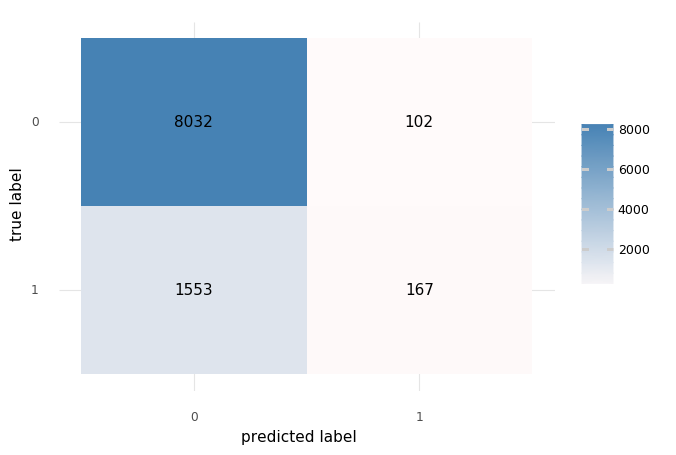

<ggplot: (116618678006)>

In [47]:
cnf_matrix = confusion_matrix( y_te, grid_logit.predict(X_te) )
plot_confusion_matrix(cnf_matrix, normalize=False)

In [48]:
(8032+167)/(1553+8032+102+167)

0.8320478993302213

### Another test with more features or "X" 9 features

In [49]:
# from sklearn.model_selection import train_test_split
# #Define X and y with patsy dmatrices
# X = df[['GROSS SQUARE FEET','TOTAL UNITS','LAND SQUARE FEET','BOROUGH', 'BUILDING CLASS CATEGORY','NEIGHBORHOOD','RESIDENTIAL UNITS','BLOCK'
          
#           ]] #features we think may help predict y
# y = df['SalePrice1mill'] #what we want to predict
# #X_tr, X_te, y_tr, y_te = train_test_split(X, y, random_state = 0)
# #A brief preview of our train test split
# #print(len(X_tr), len(X_te), len(y_tr), len(y_te))



In [50]:
from patsy import dmatrices
y, X = dmatrices('SalePrice1mill ~ BOROUGH + NEIGHBORHOOD + Q("TOTAL UNITS")+ BLOCK +Q("RESIDENTIAL UNITS")+ Q("TOTAL UNITS")+ Q("GROSS SQUARE FEET") +Q("LAND SQUARE FEET")+Q("BUILDING CLASS CATEGORY")',
                 df, return_type = "dataframe")

### Logistic

In [51]:
params = {
    'C': [0.1, 1, 10, 100]
}
regression = LogisticRegression(multi_class='multinomial', solver='lbfgs')
grid_logit = GridSearchCV(estimator=regression, param_grid=params, verbose=1)
grid_logit.fit(X_tr, y_tr)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), 

GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [0.1, 1, 10, 100]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring=None, verbose=1)

In [52]:
print(grid_logit.best_score_)

0.8390501319261213


In [53]:
params = {
    'n_estimators': [10, 15], 
    'subsample': [0.25, 0.5], 
    'max_depth': [3, 4],
    'min_samples_split': [40, 60],
    'min_samples_leaf': [20, 40]
}
gbt = GradientBoostingClassifier() # RandomForestClassifier()
grid_gbt = GridSearchCV(estimator=gbt, param_grid=params, verbose=2)
grid_gbt.fit(X_tr, y_tr)

Fitting 3 folds for each of 32 candidates, totalling 96 fits
[CV] max_depth=3, min_samples_leaf=20, min_samples_split=40, n_estimators=10, subsample=0.25 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=3, min_samples_leaf=20, min_samples_split=40, n_estimators=10, subsample=0.25, total=   0.4s
[CV] max_depth=3, min_samples_leaf=20, min_samples_split=40, n_estimators=10, subsample=0.25 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=3, min_samples_leaf=20, min_samples_split=40, n_estimators=10, subsample=0.25, total=   0.4s
[CV] max_depth=3, min_samples_leaf=20, min_samples_split=40, n_estimators=10, subsample=0.25 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=3, min_samples_leaf=20, min_samples_split=40, n_estimators=10, subsample=0.25, total=   0.3s
[CV] max_depth=3, min_samples_leaf=20, min_samples_split=40, n_estimators=10, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=3, min_samples_leaf=20, min_samples_split=40, n_estimators=10, subsample=0.5, total=   0.5s
[CV] max_depth=3, min_samples_leaf=20, min_samples_split=40, n_estimators=10, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=3, min_samples_leaf=20, min_samples_split=40, n_estimators=10, subsample=0.5, total=   0.5s
[CV] max_depth=3, min_samples_leaf=20, min_samples_split=40, n_estimators=10, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=3, min_samples_leaf=20, min_samples_split=40, n_estimators=10, subsample=0.5, total=   0.5s
[CV] max_depth=3, min_samples_leaf=20, min_samples_split=40, n_estimators=15, subsample=0.25 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=3, min_samples_leaf=20, min_samples_split=40, n_estimators=15, subsample=0.25, total=   0.5s
[CV] max_depth=3, min_samples_leaf=20, min_samples_split=40, n_estimators=15, subsample=0.25 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=3, min_samples_leaf=20, min_samples_split=40, n_estimators=15, subsample=0.25, total=   0.5s
[CV] max_depth=3, min_samples_leaf=20, min_samples_split=40, n_estimators=15, subsample=0.25 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=3, min_samples_leaf=20, min_samples_split=40, n_estimators=15, subsample=0.25, total=   0.5s
[CV] max_depth=3, min_samples_leaf=20, min_samples_split=40, n_estimators=15, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=3, min_samples_leaf=20, min_samples_split=40, n_estimators=15, subsample=0.5, total=   0.8s
[CV] max_depth=3, min_samples_leaf=20, min_samples_split=40, n_estimators=15, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=3, min_samples_leaf=20, min_samples_split=40, n_estimators=15, subsample=0.5, total=   0.8s
[CV] max_depth=3, min_samples_leaf=20, min_samples_split=40, n_estimators=15, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=3, min_samples_leaf=20, min_samples_split=40, n_estimators=15, subsample=0.5, total=   0.8s
[CV] max_depth=3, min_samples_leaf=20, min_samples_split=60, n_estimators=10, subsample=0.25 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=3, min_samples_leaf=20, min_samples_split=60, n_estimators=10, subsample=0.25, total=   0.4s
[CV] max_depth=3, min_samples_leaf=20, min_samples_split=60, n_estimators=10, subsample=0.25 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=3, min_samples_leaf=20, min_samples_split=60, n_estimators=10, subsample=0.25, total=   0.4s
[CV] max_depth=3, min_samples_leaf=20, min_samples_split=60, n_estimators=10, subsample=0.25 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=3, min_samples_leaf=20, min_samples_split=60, n_estimators=10, subsample=0.25, total=   0.3s
[CV] max_depth=3, min_samples_leaf=20, min_samples_split=60, n_estimators=10, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=3, min_samples_leaf=20, min_samples_split=60, n_estimators=10, subsample=0.5, total=   0.5s
[CV] max_depth=3, min_samples_leaf=20, min_samples_split=60, n_estimators=10, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=3, min_samples_leaf=20, min_samples_split=60, n_estimators=10, subsample=0.5, total=   0.5s
[CV] max_depth=3, min_samples_leaf=20, min_samples_split=60, n_estimators=10, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=3, min_samples_leaf=20, min_samples_split=60, n_estimators=10, subsample=0.5, total=   0.5s
[CV] max_depth=3, min_samples_leaf=20, min_samples_split=60, n_estimators=15, subsample=0.25 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=3, min_samples_leaf=20, min_samples_split=60, n_estimators=15, subsample=0.25, total=   0.6s
[CV] max_depth=3, min_samples_leaf=20, min_samples_split=60, n_estimators=15, subsample=0.25 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=3, min_samples_leaf=20, min_samples_split=60, n_estimators=15, subsample=0.25, total=   0.5s
[CV] max_depth=3, min_samples_leaf=20, min_samples_split=60, n_estimators=15, subsample=0.25 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=3, min_samples_leaf=20, min_samples_split=60, n_estimators=15, subsample=0.25, total=   0.5s
[CV] max_depth=3, min_samples_leaf=20, min_samples_split=60, n_estimators=15, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=3, min_samples_leaf=20, min_samples_split=60, n_estimators=15, subsample=0.5, total=   0.8s
[CV] max_depth=3, min_samples_leaf=20, min_samples_split=60, n_estimators=15, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=3, min_samples_leaf=20, min_samples_split=60, n_estimators=15, subsample=0.5, total=   0.8s
[CV] max_depth=3, min_samples_leaf=20, min_samples_split=60, n_estimators=15, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=3, min_samples_leaf=20, min_samples_split=60, n_estimators=15, subsample=0.5, total=   0.8s
[CV] max_depth=3, min_samples_leaf=40, min_samples_split=40, n_estimators=10, subsample=0.25 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=3, min_samples_leaf=40, min_samples_split=40, n_estimators=10, subsample=0.25, total=   0.3s
[CV] max_depth=3, min_samples_leaf=40, min_samples_split=40, n_estimators=10, subsample=0.25 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=3, min_samples_leaf=40, min_samples_split=40, n_estimators=10, subsample=0.25, total=   0.4s
[CV] max_depth=3, min_samples_leaf=40, min_samples_split=40, n_estimators=10, subsample=0.25 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=3, min_samples_leaf=40, min_samples_split=40, n_estimators=10, subsample=0.25, total=   0.3s
[CV] max_depth=3, min_samples_leaf=40, min_samples_split=40, n_estimators=10, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=3, min_samples_leaf=40, min_samples_split=40, n_estimators=10, subsample=0.5, total=   0.5s
[CV] max_depth=3, min_samples_leaf=40, min_samples_split=40, n_estimators=10, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=3, min_samples_leaf=40, min_samples_split=40, n_estimators=10, subsample=0.5, total=   0.5s
[CV] max_depth=3, min_samples_leaf=40, min_samples_split=40, n_estimators=10, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=3, min_samples_leaf=40, min_samples_split=40, n_estimators=10, subsample=0.5, total=   0.5s
[CV] max_depth=3, min_samples_leaf=40, min_samples_split=40, n_estimators=15, subsample=0.25 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=3, min_samples_leaf=40, min_samples_split=40, n_estimators=15, subsample=0.25, total=   0.5s
[CV] max_depth=3, min_samples_leaf=40, min_samples_split=40, n_estimators=15, subsample=0.25 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=3, min_samples_leaf=40, min_samples_split=40, n_estimators=15, subsample=0.25, total=   0.5s
[CV] max_depth=3, min_samples_leaf=40, min_samples_split=40, n_estimators=15, subsample=0.25 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=3, min_samples_leaf=40, min_samples_split=40, n_estimators=15, subsample=0.25, total=   0.5s
[CV] max_depth=3, min_samples_leaf=40, min_samples_split=40, n_estimators=15, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=3, min_samples_leaf=40, min_samples_split=40, n_estimators=15, subsample=0.5, total=   0.8s
[CV] max_depth=3, min_samples_leaf=40, min_samples_split=40, n_estimators=15, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=3, min_samples_leaf=40, min_samples_split=40, n_estimators=15, subsample=0.5, total=   0.8s
[CV] max_depth=3, min_samples_leaf=40, min_samples_split=40, n_estimators=15, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=3, min_samples_leaf=40, min_samples_split=40, n_estimators=15, subsample=0.5, total=   0.7s
[CV] max_depth=3, min_samples_leaf=40, min_samples_split=60, n_estimators=10, subsample=0.25 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=3, min_samples_leaf=40, min_samples_split=60, n_estimators=10, subsample=0.25, total=   0.3s
[CV] max_depth=3, min_samples_leaf=40, min_samples_split=60, n_estimators=10, subsample=0.25 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=3, min_samples_leaf=40, min_samples_split=60, n_estimators=10, subsample=0.25, total=   0.4s
[CV] max_depth=3, min_samples_leaf=40, min_samples_split=60, n_estimators=10, subsample=0.25 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=3, min_samples_leaf=40, min_samples_split=60, n_estimators=10, subsample=0.25, total=   0.4s
[CV] max_depth=3, min_samples_leaf=40, min_samples_split=60, n_estimators=10, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=3, min_samples_leaf=40, min_samples_split=60, n_estimators=10, subsample=0.5, total=   0.5s
[CV] max_depth=3, min_samples_leaf=40, min_samples_split=60, n_estimators=10, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=3, min_samples_leaf=40, min_samples_split=60, n_estimators=10, subsample=0.5, total=   0.5s
[CV] max_depth=3, min_samples_leaf=40, min_samples_split=60, n_estimators=10, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=3, min_samples_leaf=40, min_samples_split=60, n_estimators=10, subsample=0.5, total=   0.5s
[CV] max_depth=3, min_samples_leaf=40, min_samples_split=60, n_estimators=15, subsample=0.25 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=3, min_samples_leaf=40, min_samples_split=60, n_estimators=15, subsample=0.25, total=   0.5s
[CV] max_depth=3, min_samples_leaf=40, min_samples_split=60, n_estimators=15, subsample=0.25 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=3, min_samples_leaf=40, min_samples_split=60, n_estimators=15, subsample=0.25, total=   0.5s
[CV] max_depth=3, min_samples_leaf=40, min_samples_split=60, n_estimators=15, subsample=0.25 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=3, min_samples_leaf=40, min_samples_split=60, n_estimators=15, subsample=0.25, total=   0.5s
[CV] max_depth=3, min_samples_leaf=40, min_samples_split=60, n_estimators=15, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=3, min_samples_leaf=40, min_samples_split=60, n_estimators=15, subsample=0.5, total=   0.8s
[CV] max_depth=3, min_samples_leaf=40, min_samples_split=60, n_estimators=15, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=3, min_samples_leaf=40, min_samples_split=60, n_estimators=15, subsample=0.5, total=   0.7s
[CV] max_depth=3, min_samples_leaf=40, min_samples_split=60, n_estimators=15, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=3, min_samples_leaf=40, min_samples_split=60, n_estimators=15, subsample=0.5, total=   0.7s
[CV] max_depth=4, min_samples_leaf=20, min_samples_split=40, n_estimators=10, subsample=0.25 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=4, min_samples_leaf=20, min_samples_split=40, n_estimators=10, subsample=0.25, total=   0.4s
[CV] max_depth=4, min_samples_leaf=20, min_samples_split=40, n_estimators=10, subsample=0.25 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=4, min_samples_leaf=20, min_samples_split=40, n_estimators=10, subsample=0.25, total=   0.4s
[CV] max_depth=4, min_samples_leaf=20, min_samples_split=40, n_estimators=10, subsample=0.25 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=4, min_samples_leaf=20, min_samples_split=40, n_estimators=10, subsample=0.25, total=   0.4s
[CV] max_depth=4, min_samples_leaf=20, min_samples_split=40, n_estimators=10, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=4, min_samples_leaf=20, min_samples_split=40, n_estimators=10, subsample=0.5, total=   0.6s
[CV] max_depth=4, min_samples_leaf=20, min_samples_split=40, n_estimators=10, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=4, min_samples_leaf=20, min_samples_split=40, n_estimators=10, subsample=0.5, total=   0.6s
[CV] max_depth=4, min_samples_leaf=20, min_samples_split=40, n_estimators=10, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=4, min_samples_leaf=20, min_samples_split=40, n_estimators=10, subsample=0.5, total=   0.6s
[CV] max_depth=4, min_samples_leaf=20, min_samples_split=40, n_estimators=15, subsample=0.25 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=4, min_samples_leaf=20, min_samples_split=40, n_estimators=15, subsample=0.25, total=   0.6s
[CV] max_depth=4, min_samples_leaf=20, min_samples_split=40, n_estimators=15, subsample=0.25 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=4, min_samples_leaf=20, min_samples_split=40, n_estimators=15, subsample=0.25, total=   0.6s
[CV] max_depth=4, min_samples_leaf=20, min_samples_split=40, n_estimators=15, subsample=0.25 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=4, min_samples_leaf=20, min_samples_split=40, n_estimators=15, subsample=0.25, total=   0.6s
[CV] max_depth=4, min_samples_leaf=20, min_samples_split=40, n_estimators=15, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=4, min_samples_leaf=20, min_samples_split=40, n_estimators=15, subsample=0.5, total=   1.0s
[CV] max_depth=4, min_samples_leaf=20, min_samples_split=40, n_estimators=15, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=4, min_samples_leaf=20, min_samples_split=40, n_estimators=15, subsample=0.5, total=   1.0s
[CV] max_depth=4, min_samples_leaf=20, min_samples_split=40, n_estimators=15, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=4, min_samples_leaf=20, min_samples_split=40, n_estimators=15, subsample=0.5, total=   1.0s
[CV] max_depth=4, min_samples_leaf=20, min_samples_split=60, n_estimators=10, subsample=0.25 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=4, min_samples_leaf=20, min_samples_split=60, n_estimators=10, subsample=0.25, total=   0.4s
[CV] max_depth=4, min_samples_leaf=20, min_samples_split=60, n_estimators=10, subsample=0.25 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=4, min_samples_leaf=20, min_samples_split=60, n_estimators=10, subsample=0.25, total=   0.4s
[CV] max_depth=4, min_samples_leaf=20, min_samples_split=60, n_estimators=10, subsample=0.25 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=4, min_samples_leaf=20, min_samples_split=60, n_estimators=10, subsample=0.25, total=   0.4s
[CV] max_depth=4, min_samples_leaf=20, min_samples_split=60, n_estimators=10, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=4, min_samples_leaf=20, min_samples_split=60, n_estimators=10, subsample=0.5, total=   0.6s
[CV] max_depth=4, min_samples_leaf=20, min_samples_split=60, n_estimators=10, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=4, min_samples_leaf=20, min_samples_split=60, n_estimators=10, subsample=0.5, total=   0.6s
[CV] max_depth=4, min_samples_leaf=20, min_samples_split=60, n_estimators=10, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=4, min_samples_leaf=20, min_samples_split=60, n_estimators=10, subsample=0.5, total=   0.6s
[CV] max_depth=4, min_samples_leaf=20, min_samples_split=60, n_estimators=15, subsample=0.25 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=4, min_samples_leaf=20, min_samples_split=60, n_estimators=15, subsample=0.25, total=   0.6s
[CV] max_depth=4, min_samples_leaf=20, min_samples_split=60, n_estimators=15, subsample=0.25 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=4, min_samples_leaf=20, min_samples_split=60, n_estimators=15, subsample=0.25, total=   0.6s
[CV] max_depth=4, min_samples_leaf=20, min_samples_split=60, n_estimators=15, subsample=0.25 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=4, min_samples_leaf=20, min_samples_split=60, n_estimators=15, subsample=0.25, total=   0.6s
[CV] max_depth=4, min_samples_leaf=20, min_samples_split=60, n_estimators=15, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=4, min_samples_leaf=20, min_samples_split=60, n_estimators=15, subsample=0.5, total=   1.0s
[CV] max_depth=4, min_samples_leaf=20, min_samples_split=60, n_estimators=15, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=4, min_samples_leaf=20, min_samples_split=60, n_estimators=15, subsample=0.5, total=   1.2s
[CV] max_depth=4, min_samples_leaf=20, min_samples_split=60, n_estimators=15, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=4, min_samples_leaf=20, min_samples_split=60, n_estimators=15, subsample=0.5, total=   1.2s
[CV] max_depth=4, min_samples_leaf=40, min_samples_split=40, n_estimators=10, subsample=0.25 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=4, min_samples_leaf=40, min_samples_split=40, n_estimators=10, subsample=0.25, total=   0.5s
[CV] max_depth=4, min_samples_leaf=40, min_samples_split=40, n_estimators=10, subsample=0.25 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=4, min_samples_leaf=40, min_samples_split=40, n_estimators=10, subsample=0.25, total=   0.5s
[CV] max_depth=4, min_samples_leaf=40, min_samples_split=40, n_estimators=10, subsample=0.25 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=4, min_samples_leaf=40, min_samples_split=40, n_estimators=10, subsample=0.25, total=   0.4s
[CV] max_depth=4, min_samples_leaf=40, min_samples_split=40, n_estimators=10, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=4, min_samples_leaf=40, min_samples_split=40, n_estimators=10, subsample=0.5, total=   0.6s
[CV] max_depth=4, min_samples_leaf=40, min_samples_split=40, n_estimators=10, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=4, min_samples_leaf=40, min_samples_split=40, n_estimators=10, subsample=0.5, total=   0.6s
[CV] max_depth=4, min_samples_leaf=40, min_samples_split=40, n_estimators=10, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=4, min_samples_leaf=40, min_samples_split=40, n_estimators=10, subsample=0.5, total=   0.7s
[CV] max_depth=4, min_samples_leaf=40, min_samples_split=40, n_estimators=15, subsample=0.25 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=4, min_samples_leaf=40, min_samples_split=40, n_estimators=15, subsample=0.25, total=   0.7s
[CV] max_depth=4, min_samples_leaf=40, min_samples_split=40, n_estimators=15, subsample=0.25 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=4, min_samples_leaf=40, min_samples_split=40, n_estimators=15, subsample=0.25, total=   0.6s
[CV] max_depth=4, min_samples_leaf=40, min_samples_split=40, n_estimators=15, subsample=0.25 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=4, min_samples_leaf=40, min_samples_split=40, n_estimators=15, subsample=0.25, total=   0.6s
[CV] max_depth=4, min_samples_leaf=40, min_samples_split=40, n_estimators=15, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=4, min_samples_leaf=40, min_samples_split=40, n_estimators=15, subsample=0.5, total=   1.0s
[CV] max_depth=4, min_samples_leaf=40, min_samples_split=40, n_estimators=15, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=4, min_samples_leaf=40, min_samples_split=40, n_estimators=15, subsample=0.5, total=   1.0s
[CV] max_depth=4, min_samples_leaf=40, min_samples_split=40, n_estimators=15, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=4, min_samples_leaf=40, min_samples_split=40, n_estimators=15, subsample=0.5, total=   1.0s
[CV] max_depth=4, min_samples_leaf=40, min_samples_split=60, n_estimators=10, subsample=0.25 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=4, min_samples_leaf=40, min_samples_split=60, n_estimators=10, subsample=0.25, total=   0.4s
[CV] max_depth=4, min_samples_leaf=40, min_samples_split=60, n_estimators=10, subsample=0.25 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=4, min_samples_leaf=40, min_samples_split=60, n_estimators=10, subsample=0.25, total=   0.4s
[CV] max_depth=4, min_samples_leaf=40, min_samples_split=60, n_estimators=10, subsample=0.25 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=4, min_samples_leaf=40, min_samples_split=60, n_estimators=10, subsample=0.25, total=   0.4s
[CV] max_depth=4, min_samples_leaf=40, min_samples_split=60, n_estimators=10, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=4, min_samples_leaf=40, min_samples_split=60, n_estimators=10, subsample=0.5, total=   0.6s
[CV] max_depth=4, min_samples_leaf=40, min_samples_split=60, n_estimators=10, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=4, min_samples_leaf=40, min_samples_split=60, n_estimators=10, subsample=0.5, total=   0.6s
[CV] max_depth=4, min_samples_leaf=40, min_samples_split=60, n_estimators=10, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=4, min_samples_leaf=40, min_samples_split=60, n_estimators=10, subsample=0.5, total=   0.7s
[CV] max_depth=4, min_samples_leaf=40, min_samples_split=60, n_estimators=15, subsample=0.25 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=4, min_samples_leaf=40, min_samples_split=60, n_estimators=15, subsample=0.25, total=   0.7s
[CV] max_depth=4, min_samples_leaf=40, min_samples_split=60, n_estimators=15, subsample=0.25 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=4, min_samples_leaf=40, min_samples_split=60, n_estimators=15, subsample=0.25, total=   0.6s
[CV] max_depth=4, min_samples_leaf=40, min_samples_split=60, n_estimators=15, subsample=0.25 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=4, min_samples_leaf=40, min_samples_split=60, n_estimators=15, subsample=0.25, total=   0.6s
[CV] max_depth=4, min_samples_leaf=40, min_samples_split=60, n_estimators=15, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=4, min_samples_leaf=40, min_samples_split=60, n_estimators=15, subsample=0.5, total=   0.9s
[CV] max_depth=4, min_samples_leaf=40, min_samples_split=60, n_estimators=15, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=4, min_samples_leaf=40, min_samples_split=60, n_estimators=15, subsample=0.5, total=   0.9s
[CV] max_depth=4, min_samples_leaf=40, min_samples_split=60, n_estimators=15, subsample=0.5 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=4, min_samples_leaf=40, min_samples_split=60, n_estimators=15, subsample=0.5, total=   0.9s


[Parallel(n_jobs=1)]: Done  96 out of  96 | elapsed:  1.2min finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GridSearchCV(cv=None, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [10, 15], 'subsample': [0.25, 0.5], 'max_depth': [3, 4], 'min_samples_split': [40, 60], 'min_samples_leaf': [20, 40]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

In [54]:
print(grid_gbt.best_estimator_)
print(grid_gbt.best_score_)
pd.DataFrame(grid_gbt.cv_results_)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=4,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=20, min_samples_split=40,
              min_weight_fraction_leaf=0.0, n_estimators=15,
              presort='auto', random_state=None, subsample=0.5, verbose=0,
              warm_start=False)
0.8487247141600703


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\util

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_n_estimators,param_subsample,params,...,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0.465963,0.041285,0.004099,0.005797,3,20,40,10,0.25,"{'max_depth': 3, 'min_samples_leaf': 20, 'min_...",...,0.845342,0.842602,0.843921,0.001121,23,0.844733,0.842501,0.844073,0.843769,0.000937
1,0.576236,0.003340,0.010414,0.007364,3,20,40,10,0.5,"{'max_depth': 3, 'min_samples_leaf': 20, 'min_...",...,0.844530,0.843718,0.843515,0.000923,25,0.844479,0.841993,0.845951,0.844141,0.001633
2,0.583819,0.007749,0.013242,0.002886,3,20,40,15,0.25,"{'max_depth': 3, 'min_samples_leaf': 20, 'min_...",...,0.847473,0.844226,0.844835,0.001954,21,0.845748,0.844835,0.846813,0.845799,0.000809
3,0.899676,0.025236,0.017979,0.004954,3,20,40,15,0.5,"{'max_depth': 3, 'min_samples_leaf': 20, 'min_...",...,0.848691,0.844632,0.846255,0.001754,9,0.847372,0.845342,0.846966,0.846560,0.000877
4,0.465371,0.026745,0.015185,0.001699,3,20,60,10,0.25,"{'max_depth': 3, 'min_samples_leaf': 20, 'min_...",...,0.845748,0.842906,0.843143,0.002037,28,0.842450,0.843871,0.844581,0.843634,0.000886
5,0.599871,0.003255,0.014679,0.007219,3,20,60,10,0.5,"{'max_depth': 3, 'min_samples_leaf': 20, 'min_...",...,0.847270,0.843921,0.844090,0.002530,22,0.843109,0.845241,0.846661,0.845004,0.001460
6,0.605385,0.031081,0.011041,0.007997,3,20,60,15,0.25,"{'max_depth': 3, 'min_samples_leaf': 20, 'min_...",...,0.846357,0.846458,0.844970,0.002034,19,0.844784,0.844175,0.848437,0.845799,0.001882
7,0.867337,0.017000,0.013599,0.002978,3,20,60,15,0.5,"{'max_depth': 3, 'min_samples_leaf': 20, 'min_...",...,0.847778,0.846458,0.846932,0.000599,8,0.848488,0.845190,0.848742,0.847473,0.001618
8,0.430346,0.024214,0.011686,0.008341,3,40,40,10,0.25,"{'max_depth': 3, 'min_samples_leaf': 40, 'min_...",...,0.844835,0.841587,0.841892,0.002289,31,0.840978,0.842196,0.842145,0.841773,0.000562
9,0.587395,0.017855,0.008788,0.006526,3,40,40,10,0.5,"{'max_depth': 3, 'min_samples_leaf': 40, 'min_...",...,0.845748,0.841790,0.843279,0.001758,27,0.843769,0.843668,0.843008,0.843481,0.000337


### Confusion Matrix

C:\ProgramData\Anaconda3\lib\site-packages\plotnine\utils.py:281: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  ndistinct = ids.apply(len_unique, axis=0).as_matrix()
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:4388: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  object.__getattribute__(self, name)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:4389: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  return object.__setattr__(self, name, value)


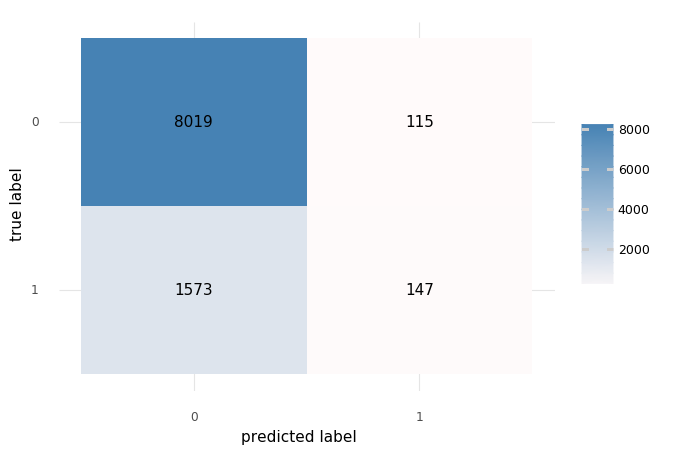

<ggplot: (116618692991)>

In [55]:
cnf_matrix = confusion_matrix( y_te, grid_logit.predict(X_te) )
plot_confusion_matrix(cnf_matrix, normalize=False)


In [56]:
(8019+147)/(8019+1573+115+147)

0.8286990054800081